### CREDIT

This notebook is prepared by the guidance of  Devjyoti Chakraborty's blogs from Pyimagesearch. Most of the code blocks and explanations are taken from these blogs. You can reach original codes and detailed explanations from references.

#### WHAT IS THIS NOTEBOOK

This notebook is an example about SRGAN by keras and TF. We will implement SRGAN for div2k/bicubic_x4 dataset from Tensorflow. 


#### Keywords

* SRGAN
* Super Resolution
* GAN
* TF 
* div2k/bicubic_x4 dataset TF

Define our configurations...


In [1]:
# import the necessary packages
import os

# name of the TFDS dataset we will be using
DATASET = "div2k/bicubic_x4"

# define the shard size and batch size
SHARD_SIZE = 256
TRAIN_BATCH_SIZE = 64
INFER_BATCH_SIZE = 8

# dataset specs
HR_SHAPE = [96, 96, 3]
LR_SHAPE = [24, 24, 3]
SCALING_FACTOR = 4

# GAN model specs
FEATURE_MAPS = 64
RESIDUAL_BLOCKS = 16
LEAKY_ALPHA = 0.2
DISC_BLOCKS = 4

# training specs
PRETRAIN_LR = 1e-4
FINETUNE_LR = 1e-5
PRETRAIN_EPOCHS = 2500
FINETUNE_EPOCHS = 2500
STEPS_PER_EPOCH = 10

# define the path to the dataset
BASE_DATA_PATH = "dataset"
DIV2K_PATH = os.path.join(BASE_DATA_PATH, "div2k")

# define the path to the tfrecords for GPU training
GPU_BASE_TFR_PATH = "tfrecord"
GPU_DIV2K_TFR_TRAIN_PATH = os.path.join(GPU_BASE_TFR_PATH, "train")
GPU_DIV2K_TFR_TEST_PATH = os.path.join(GPU_BASE_TFR_PATH, "test")

# define the path to the tfrecords for TPU training
TPU_BASE_TFR_PATH = "gs://<PATH_TO_GCS_BUCKET>/tfrecord"
TPU_DIV2K_TFR_TRAIN_PATH = os.path.join(TPU_BASE_TFR_PATH, "train")
TPU_DIV2K_TFR_TEST_PATH = os.path.join(TPU_BASE_TFR_PATH, "test")

# path to our base output directory
BASE_OUTPUT_PATH = "outputs"

# GPU training SRGAN model paths
GPU_PRETRAINED_GENERATOR_MODEL = os.path.join(BASE_OUTPUT_PATH,
	"models", "pretrained_generator")
GPU_GENERATOR_MODEL = os.path.join(BASE_OUTPUT_PATH, "models",
	"generator")

# TPU training SRGAN model paths
TPU_OUTPUT_PATH = "gs://<PATH_TO_GCS_BUCKET>/outputs"
TPU_PRETRAINED_GENERATOR_MODEL = os.path.join(TPU_OUTPUT_PATH,
	"models", "pretrained_generator")
TPU_GENERATOR_MODEL = os.path.join(TPU_OUTPUT_PATH, "models",
	"generator")

# define the path to the inferred images and to the grid image
BASE_IMAGE_PATH = os.path.join(BASE_OUTPUT_PATH, "images")
GRID_IMAGE_PATH = os.path.join(BASE_IMAGE_PATH, "grid.png")

We need lots of data for training GANs, because of that we have to apply data augmentation..

In [21]:
from tensorflow.io import FixedLenFeature
from tensorflow.io import parse_single_example
from tensorflow.io import parse_tensor
from tensorflow.image import flip_left_right
from tensorflow.image import rot90
import tensorflow as tf

# define AUTOTUNE object
AUTO = tf.data.AUTOTUNE

def random_crop(lrImage, hrImage, hrCropSize=96, scale=4):
    # calculate the low resolution image crop size and image shape
    lrCropSize = hrCropSize // scale
    lrImageShape = tf.shape(lrImage)[:2]

    # calculate the low resolution image width and height offsets
    lrW = tf.random.uniform(shape=(),
        maxval=lrImageShape[1] - lrCropSize + 1, dtype=tf.int32)
    lrH = tf.random.uniform(shape=(),
        maxval=lrImageShape[0] - lrCropSize + 1, dtype=tf.int32)

    # calculate the high resolution image width and height
    hrW = lrW * scale
    hrH = lrH * scale

    # crop the low and high resolution images
    lrImageCropped = tf.slice(lrImage, [lrH, lrW, 0], 
        [(lrCropSize), (lrCropSize), 3])
    hrImageCropped = tf.slice(hrImage, [hrH, hrW, 0],
        [(hrCropSize), (hrCropSize), 3])

    # return the cropped low and high resolution images
    return (lrImageCropped, hrImageCropped)

def get_center_crop(lrImage, hrImage, hrCropSize=96, scale=4):
    # calculate the low resolution image crop size and image shape
    lrCropSize = hrCropSize // scale
    lrImageShape = tf.shape(lrImage)[:2]

    # calculate the low resolution image width and height
    lrW = lrImageShape[1] // 2
    lrH = lrImageShape[0] // 2

    # calculate the high resolution image width and height
    hrW = lrW * scale
    hrH = lrH * scale

    # crop the low and high resolution images
    lrImageCropped = tf.slice(lrImage, [lrH - (lrCropSize // 2),
        lrW - (lrCropSize // 2), 0], [lrCropSize, lrCropSize, 3])
    hrImageCropped = tf.slice(hrImage, [hrH - (hrCropSize // 2),
        hrW - (hrCropSize // 2), 0], [hrCropSize, hrCropSize, 3])

    # return the cropped low and high resolution images
    return (lrImageCropped, hrImageCropped)

def random_flip(lrImage, hrImage):
    # calculate a random chance for flip
    flipProb = tf.random.uniform(shape=(), maxval=1)
    (lrImage, hrImage) = tf.cond(flipProb < 0.5,
        lambda: (lrImage, hrImage),
        lambda: (flip_left_right(lrImage), flip_left_right(hrImage)))

    # return the randomly flipped low and high resolution images
    return (lrImage, hrImage)

def random_rotate(lrImage, hrImage):
    # randomly generate the number of 90 degree rotations
    n = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)

    # rotate the low and high resolution images
    lrImage = rot90(lrImage, n)
    hrImage = rot90(hrImage, n)

    # return the randomly rotated images
    return (lrImage, hrImage)

Augmentation will be applied only on Training dataset, not test set...

In [2]:
def read_train_example(example):
    # get the feature template and  parse a single image according to
    # the feature template
    feature = {
        "lr": FixedLenFeature([], tf.string),
        "hr": FixedLenFeature([], tf.string),
    }
    example = parse_single_example(example, feature)

    # parse the low and high resolution images
    lrImage = parse_tensor(example["lr"], out_type=tf.uint8)
    hrImage = parse_tensor(example["hr"], out_type=tf.uint8)

    # perform data augmentation
    (lrImage, hrImage) = random_crop(lrImage, hrImage)
    (lrImage, hrImage) = random_flip(lrImage, hrImage)
    (lrImage, hrImage) = random_rotate(lrImage, hrImage)

    # reshape the low and high resolution images
    lrImage = tf.reshape(lrImage, (24, 24, 3))
    hrImage = tf.reshape(hrImage, (96, 96, 3))

    # return the low and high resolution images
    return (lrImage, hrImage)

def read_test_example(example):
    # get the feature template and  parse a single image according to
    # the feature template
    feature = {
        "lr": FixedLenFeature([], tf.string),
        "hr": FixedLenFeature([], tf.string),
    }
    example = parse_single_example(example, feature)

    # parse the low and high resolution images
    lrImage = parse_tensor(example["lr"], out_type=tf.uint8)
    hrImage = parse_tensor(example["hr"], out_type=tf.uint8)

    # center crop both low and high resolution image
    (lrImage, hrImage) = get_center_crop(lrImage, hrImage)

    # reshape the low and high resolution images
    lrImage = tf.reshape(lrImage, (24, 24, 3))
    hrImage = tf.reshape(hrImage, (96, 96, 3))

    # return the low and high resolution images
    return (lrImage, hrImage)

There will be a 'train' boolean for loading dataset...

In [3]:
def load_dataset(filenames, batchSize, train=False):
    # get the TFRecords from the filenames
    dataset = tf.data.TFRecordDataset(filenames, 
        num_parallel_reads=AUTO)

    # check if this is the training dataset
    if train:
        # read the training examples
        dataset = dataset.map(read_train_example,
            num_parallel_calls=AUTO)
    # otherwise, we are working with the test dataset
    else:
        # read the test examples
        dataset = dataset.map(read_test_example,
            num_parallel_calls=AUTO)

    # batch and prefetch the data
    dataset = (dataset
        .shuffle(batchSize)
        .batch(batchSize)
        .repeat()
        .prefetch(AUTO)
    )

    # return the dataset
    return dataset

Define Losses...

In [4]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import Reduction
from tensorflow import reduce_mean

class Losses:
    def __init__(self, numReplicas):
        self.numReplicas = numReplicas

    def bce_loss(self, real, pred):
        # compute binary cross entropy loss without reduction
        BCE = BinaryCrossentropy(reduction=Reduction.NONE)
        loss = BCE(real, pred)

        # compute reduced mean over the entire batch
        loss = reduce_mean(loss) * (1. / self.numReplicas)

        # return reduced bce loss
        return loss

    def mse_loss(self, real, pred):
        # compute mean squared error loss without reduction
        MSE = MeanSquaredError(reduction=Reduction.NONE)
        loss = MSE(real, pred)

        # compute reduced mean over the entire batch
        loss = reduce_mean(loss) * (1. / self.numReplicas)

        # return reduced mse loss
        return loss

In [5]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import savefig
from matplotlib.pyplot import title
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from matplotlib.pyplot import show
from tensorflow.keras.preprocessing.image import array_to_img
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import os

# the following code snippet has been taken from:
# https://keras.io/examples/vision/super_resolution_sub_pixel
def zoom_into_images(image, imageTitle):
    # create a new figure with a default 111 subplot.
    (fig, ax) = subplots()
    im = ax.imshow(array_to_img(image[::-1]), origin="lower")

    title(imageTitle)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(array_to_img(image[::-1]), origin="lower")

    # specify the limits.
    (x1, x2, y1, y2) = 20, 40, 20, 40
    # apply the x-limits.
    axins.set_xlim(x1, x2)
    # apply the y-limits.
    axins.set_ylim(y1, y2)

    # remove the xticks and yticks
    yticks(visible=False)
    xticks(visible=False)

    # make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")

    # build the image path and save it to disk
    imagePath = os.path.join(BASE_IMAGE_PATH,
        f"{imageTitle}.png")
    savefig(imagePath)

    # show the image
    show()

We need VGG19 from Tensorflow...with its first 20 layers


In [6]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model

class VGG:
    @staticmethod
    def build():
        # initialize the pre-trained VGG19 model
        vgg = VGG19(input_shape=(None, None, 3), weights="imagenet",
            include_top=False)

        # slicing the VGG19 model till layer #20
        model = Model(vgg.input, vgg.layers[20].output)

        # return the sliced VGG19 model
        return model

SRGAN generator and discliminator....

In [7]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Add
from tensorflow.nn import depth_to_space
from tensorflow.keras import Model
from tensorflow.keras import Input

In [8]:
class SRGAN(object):
    @staticmethod
    def generator(scalingFactor, featureMaps, residualBlocks):
        # initialize the input layer
        inputs = Input((None, None, 3))
        xIn = Rescaling(scale=(1.0 / 255.0), offset=0.0)(inputs)

        # pass the input through CONV => PReLU block
        xIn = Conv2D(featureMaps, 9, padding="same")(xIn)
        xIn = PReLU(shared_axes=[1, 2])(xIn)

        # construct the "residual in residual" block
        x = Conv2D(featureMaps, 3, padding="same")(xIn)
        x = BatchNormalization()(x)
        x = PReLU(shared_axes=[1, 2])(x)
        x = Conv2D(featureMaps, 3, padding="same")(x)
        x = BatchNormalization()(x)
        xSkip = Add()([xIn, x])

        # create a number of residual blocks
        for _ in range(residualBlocks - 1):
            x = Conv2D(featureMaps, 3, padding="same")(xSkip)
            x = BatchNormalization()(x)
            x = PReLU(shared_axes=[1, 2])(x)
            x = Conv2D(featureMaps, 3, padding="same")(x)
            x = BatchNormalization()(x)
            xSkip = Add()([xSkip, x])

        # get the last residual block without activation
        x = Conv2D(featureMaps, 3, padding="same")(xSkip)
        x = BatchNormalization()(x)
        x = Add()([xIn, x])

        # upscale the image with pixel shuffle
        x = Conv2D(featureMaps * (scalingFactor // 2), 3, padding="same")(x)
        x = depth_to_space(x, 2)
        x = PReLU(shared_axes=[1, 2])(x)

        # upscale the image with pixel shuffle
        x = Conv2D(featureMaps * scalingFactor, 3,
            padding="same")(x)
        x = depth_to_space(x, 2)
        x = PReLU(shared_axes=[1, 2])(x)

        # get the output and scale it from [-1, 1] to [0, 255] range
        x = Conv2D(3, 9, padding="same", activation="tanh")(x)
        x = Rescaling(scale=127.5, offset=127.5)(x)

        # create the generator model
        generator = Model(inputs, x)

        # return the generator
        return generator

    @staticmethod
    def discriminator(featureMaps, leakyAlpha, discBlocks):
        # initialize the input layer and process it with conv kernel
        inputs = Input((None, None, 3))
        x = Rescaling(scale=(1.0 / 127.5), offset=-1.0)(inputs)
        x = Conv2D(featureMaps, 3, padding="same")(x)

        # unlike the generator we use leaky relu in the discriminator
        x = LeakyReLU(leakyAlpha)(x)

        # pass the output from previous layer through a CONV => BN =>
        # LeakyReLU block
        x = Conv2D(featureMaps, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(leakyAlpha)(x)

        # create a number of discriminator blocks
        for i in range(1, discBlocks):
            # first CONV => BN => LeakyReLU block
            x = Conv2D(featureMaps * (2 ** i), 3, strides=2,
                padding="same")(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(leakyAlpha)(x)

            # second CONV => BN => LeakyReLU block
            x = Conv2D(featureMaps * (2 ** i), 3, padding="same")(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(leakyAlpha)(x)

        # process the feature maps with global average pooling
        x = GlobalAvgPool2D()(x)
        x = LeakyReLU(leakyAlpha)(x)

        # final FC layer with sigmoid activation function
        x = Dense(1, activation="sigmoid")(x)

        # create the discriminator model
        discriminator = Model(inputs, x)

        # return the discriminator
        return discriminator

In [9]:
from tensorflow.keras import Model
from tensorflow import GradientTape
from tensorflow import concat
from tensorflow import zeros
from tensorflow import ones
import tensorflow as tf

class SRGANTraining(Model):
    def __init__(self, generator, discriminator, vgg, batchSize):
        super().__init__()
        # initialize the generator, discriminator, vgg model, and 
        # the global batch size
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg
        self.batchSize = batchSize

    def compile(self, gOptimizer, dOptimizer, bceLoss, mseLoss):
        super().compile()
        # initialize the optimizers for the generator 
        # and discriminator
        self.gOptimizer = gOptimizer
        self.dOptimizer = dOptimizer

        # initialize the loss functions
        self.bceLoss = bceLoss
        self.mseLoss = mseLoss

    def train_step(self, images):
        # grab the low and high resolution images
        (lrImages, hrImages) = images
        lrImages = tf.cast(lrImages, tf.float32)
        hrImages = tf.cast(hrImages, tf.float32)

        # generate super resolution images
        srImages = self.generator(lrImages)

        # combine them with real images
        combinedImages = concat([srImages, hrImages], axis=0)

        # assemble labels discriminating real from fake images where
        # label 0 is for predicted images and 1 is for original high
        # resolution images
        labels = concat(
            [zeros((self.batchSize, 1)), ones((self.batchSize, 1))],
            axis=0)

        # train the discriminator
        with GradientTape() as tape:
            # get the discriminator predictions
            predictions = self.discriminator(combinedImages)

            # compute the loss
            dLoss = self.bceLoss(labels, predictions)

        # compute the gradients
        grads = tape.gradient(dLoss,
            self.discriminator.trainable_variables)

        # optimise the discriminator weights according to the
        # gradients computed
        self.dOptimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_variables)
        )

        # generate misleading labels
        misleadingLabels = ones((self.batchSize, 1))

        # train the generator (note that we should *not* update the
        #  weights of the discriminator)!
        with GradientTape() as tape:
            # get fake images from the generator
            fakeImages = self.generator(lrImages)

            # get the prediction from the discriminator
            predictions = self.discriminator(fakeImages)

            # compute the adversarial loss
            gLoss = 1e-3 * self.bceLoss(misleadingLabels, predictions)

            # compute the normalized vgg outputs
            srVgg = tf.keras.applications.vgg19.preprocess_input(
                fakeImages)
            srVgg = self.vgg(srVgg) / 12.75
            hrVgg = tf.keras.applications.vgg19.preprocess_input(
                hrImages)
            hrVgg = self.vgg(hrVgg) / 12.75

            # compute the perceptual loss
            percLoss = self.mseLoss(hrVgg, srVgg)

            # calculate the total generator loss
            gTotalLoss = gLoss + percLoss

        # compute the gradients
        grads = tape.gradient(gTotalLoss,
            self.generator.trainable_variables)

        # optimise the generator weights with the computed gradients
        self.gOptimizer.apply_gradients(zip(grads,
            self.generator.trainable_variables)
        )

        # return the generator and discriminator losses
        return {"dLoss": dLoss, "gTotalLoss": gTotalLoss,
            "gLoss": gLoss, "percLoss": percLoss}

In [11]:
# import the necessary packages
from tensorflow.io import serialize_tensor
from tensorflow.io import TFRecordWriter
from tensorflow.train import BytesList
from tensorflow.train import Feature
from tensorflow.train import Features
from tensorflow.train import Example
import tensorflow_datasets as tfds
import tensorflow as tf
import os

# define AUTOTUNE object
AUTO = tf.data.AUTOTUNE

def pre_process(element):
    # grab the low and high resolution images
    lrImage = element["lr"]
    hrImage = element["hr"]

    # convert the low and high resolution images from tensor to
    # serialized TensorProto proto
    lrByte = serialize_tensor(lrImage)
    hrByte = serialize_tensor(hrImage)

    # return the low and high resolution proto objects
    return (lrByte, hrByte)

def create_dataset(dataDir, split, shardSize):
    # load the dataset, save it to disk, and preprocess it
    ds = tfds.load(DATASET, split=split, data_dir=dataDir)
    ds = (ds
        .map(pre_process, num_parallel_calls=AUTO)
        .batch(shardSize)
    )

    # return the dataset
    return ds

def create_serialized_example(lrByte, hrByte):
    # create low and high resolution image byte list
    lrBytesList = BytesList(value=[lrByte])
    hrBytesList = BytesList(value=[hrByte])

    # build low and high resolution image feature from the byte list
    lrFeature = Feature(bytes_list=lrBytesList)
    hrFeature = Feature(bytes_list=hrBytesList)

    # build a low and high resolution image feature map
    featureMap = {
        "lr": lrFeature,
        "hr": hrFeature,
    }

    # build a collection of features, followed by building example
    # from features, and serializing the example
    features = Features(feature=featureMap)
    example = Example(features=features)
    serializedExample = example.SerializeToString()

    # return the serialized example
    return serializedExample

def prepare_tfrecords(dataset, outputDir, name, printEvery=50):
    # check whether output directory exists
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)

    # loop over the dataset and create TFRecords
    for (index, images) in enumerate(dataset):
        # get the shard size and build the filename
        shardSize = images[0].numpy().shape[0]
        tfrecName = f"{index:02d}-{shardSize}.tfrec"
        filename = outputDir + f"/{name}-" + tfrecName

        # write to the tfrecords
        with TFRecordWriter(filename) as outFile:
            # write shard size serialized examples to each TFRecord
            for i in range(shardSize):
                serializedExample = create_serialized_example(
                    images[0].numpy()[i], images[1].numpy()[i])
                outFile.write(serializedExample)

            # print the progress to the user
            if index % printEvery == 0:
                print("[INFO] wrote file {} containing {} records..."
                .format(filename, shardSize))


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# create training and validation dataset of the div2k images
print("[INFO] creating div2k training and testing dataset...")
trainDs = create_dataset(dataDir=DIV2K_PATH, split="train",
    shardSize=SHARD_SIZE)
testDs = create_dataset(dataDir=DIV2K_PATH, split="validation",
    shardSize=SHARD_SIZE)



[INFO] creating div2k training and testing dataset...
EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/30 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/458 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/3825 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/4060 [00:00<?, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   0%|          | 1/4060 [00:02<2:15:27,  2.00s/ MiB]

Extraction completed...: 0 file [00:02, ? file/s]
Dl Size...:   0%|          | 2/4060 [00:02<1:08:58,  1.02s/ MiB]

Dl Size...:   0%|          | 3/4060 [00:02<1:08:57,  1.02s/ MiB]

Extraction completed...: 0 file [

Dl Size...:   2%|▏         | 88/4060 [00:29<12:47,  5.18 MiB/s]

Extraction completed...: 0 file [00:29, ? file/s]
Dl Size...:   2%|▏         | 89/4060 [00:29<13:58,  4.74 MiB/s]

Extraction completed...: 0 file [00:29, ? file/s]
Dl Size...:   2%|▏         | 90/4060 [00:30<29:51,  2.22 MiB/s]

Dl Size...:   2%|▏         | 91/4060 [00:30<29:50,  2.22 MiB/s]

Extraction completed...: 0 file [00:30, ? file/s]
Dl Size...:   2%|▏         | 92/4060 [00:30<20:45,  3.19 MiB/s]

Extraction completed...: 0 file [00:30, ? file/s]
Dl Size...:   2%|▏         | 93/4060 [00:31<20:06,  3.29 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:   2%|▏         | 94/4060 [00:31<21:41,  3.05 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:   2%|▏         | 95/4060 [00:31<18:30,  3.57 MiB/s]

Extraction completed...: 0 file [00:31, ? file/s]
Dl Size...:   2%|▏         | 96/4060 [00:32<22:12,  2.98 MiB/s]

Dl Size...:   2%|▏         | 97/4060 [00:32<22:11,  2.98 MiB/s]



Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Extraction completed...:   0%|          | 0/100 [00:38<?, ? file/s]

Dl Size...:   3%|▎         | 108/4060 [00:38<23:42,  2.78 MiB/s]

Dl Size

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 109/4060 [00:39<20:04,  3.28 MiB/s]

Dl Size...:   3%|▎         | 110/4060 [00:39<19:19,  3.41 MiB/s]

Dl Size...:   3%|▎         | 111/4060 [00:39<20:54,  3.15 MiB/s]

Dl Size...:   3%|▎         | 112/4060 [00:39<21:29,  3.06 MiB/s]

Dl Size...:   3%|▎         | 113/4060 [00:40<22:29,  2.92 MiB/s]

Dl Size...:   3%|▎         | 114/4060 [00:40<19:56,  3.30 MiB/s]

Dl Size...:   3%|▎         | 115/4060 [00:41<25:55,  2.54 MiB/s]

Dl Size...:   3%|▎         | 116/4060 [00:42<40:31,  1.62 MiB/s]

Dl Size...

Dl Size...:   4%|▍         | 180/4060 [01:02<27:23,  2.36 MiB/s]

Dl Size...:   4%|▍         | 181/4060 [01:02<27:23,  2.36 MiB/s]

Dl Size...:   4%|▍         | 182/4060 [01:02<27:23,  2.36 MiB/s]

Dl Size...:   5%|▍         | 183/4060 [01:02<27:22,  2.36 MiB/s]

Dl Size...:   5%|▍         | 184/4060 [01:02<27:22,  2.36 MiB/s]

Dl Size...:   5%|▍         | 185/4060 [01:02<09:57,  6.48 MiB/s]

Dl Size...:   5%|▍         | 186/4060 [01:02<09:57,  6.48 MiB/s]

Dl Size...:   5%|▍         | 187/4060 [01:02<11:26,  5.64 MiB/s]

Dl Size...:   5%|▍         | 188/4060 [01:03<11:26,  5.64 MiB/s]

Dl Size...:   5%|▍         | 189/4060 [01:03<19:26,  3.32 MiB/s]

Dl Size...:   5%|▍         | 190/4060 [01:04<25:21,  2.54 MiB/s]

Dl Size...:   5%|▍         | 191/4060 [01:05<24:34,  2.62 MiB/s]

Dl Size...:   5%|▍         | 192/4060 [01:05<27:04,  2.38 MiB/s]

Dl Size...:   5%|▍         | 193/4060 [01:05<26:14,  2.46 MiB/s]

Dl Size...:   5%|▍         | 194/4060 [01:06<28:11,  2.29 MiB/s]

Dl Size...

Dl Size...:   6%|▋         | 257/4060 [01:24<12:12,  5.19 MiB/s]

Dl Size...:   6%|▋         | 258/4060 [01:24<12:06,  5.23 MiB/s]

Dl Size...:   6%|▋         | 259/4060 [01:24<13:36,  4.66 MiB/s]

Dl Size...:   6%|▋         | 260/4060 [01:24<16:03,  3.95 MiB/s]

Dl Size...:   6%|▋         | 261/4060 [01:25<21:09,  2.99 MiB/s]

Dl Size...:   6%|▋         | 262/4060 [01:25<20:00,  3.16 MiB/s]

Dl Size...:   6%|▋         | 263/4060 [01:25<17:25,  3.63 MiB/s]

Dl Size...:   7%|▋         | 264/4060 [01:26<33:17,  1.90 MiB/s]

Dl Size...:   7%|▋         | 265/4060 [01:28<47:59,  1.32 MiB/s]

Dl Size...:   7%|▋         | 266/4060 [01:28<38:41,  1.63 MiB/s]

Dl Size...:   7%|▋         | 267/4060 [01:28<32:57,  1.92 MiB/s]

Dl Size...:   7%|▋         | 268/4060 [01:29<26:03,  2.42 MiB/s]

Dl Size...:   7%|▋         | 269/4060 [01:29<28:16,  2.23 MiB/s]

Dl Size...:   7%|▋         | 270/4060 [01:29<22:23,  2.82 MiB/s]

Dl Size...:   7%|▋         | 271/4060 [01:29<21:13,  2.97 MiB/s]

Dl Size...

Dl Size...:   8%|▊         | 332/4060 [01:50<11:09,  5.56 MiB/s]

Dl Size...:   8%|▊         | 333/4060 [01:50<10:54,  5.70 MiB/s]

Dl Size...:   8%|▊         | 334/4060 [01:51<11:44,  5.29 MiB/s]

Dl Size...:   8%|▊         | 335/4060 [01:51<12:45,  4.86 MiB/s]

Dl Size...:   8%|▊         | 336/4060 [01:51<13:24,  4.63 MiB/s]

Dl Size...:   8%|▊         | 337/4060 [01:51<13:10,  4.71 MiB/s]

Dl Size...:   8%|▊         | 338/4060 [01:52<21:59,  2.82 MiB/s]

Dl Size...:   8%|▊         | 339/4060 [01:52<18:09,  3.41 MiB/s]

Dl Size...:   8%|▊         | 340/4060 [01:53<17:37,  3.52 MiB/s]

Dl Size...:   8%|▊         | 341/4060 [01:53<17:50,  3.47 MiB/s]

Dl Size...:   8%|▊         | 342/4060 [01:53<16:15,  3.81 MiB/s]

Dl Size...:   8%|▊         | 343/4060 [01:53<14:34,  4.25 MiB/s]

Dl Size...:   8%|▊         | 344/4060 [01:53<13:18,  4.66 MiB/s]

Dl Size...:   8%|▊         | 345/4060 [01:54<13:00,  4.76 MiB/s]

Dl Size...:   9%|▊         | 346/4060 [01:54<24:38,  2.51 MiB/s]

Dl Size...

Dl Size...:  10%|█         | 407/4060 [02:20<13:09,  4.63 MiB/s]

Dl Size...:  10%|█         | 408/4060 [02:21<14:30,  4.19 MiB/s]

Dl Size...:  10%|█         | 409/4060 [02:22<37:21,  1.63 MiB/s]

Dl Size...:  10%|█         | 410/4060 [02:23<31:55,  1.91 MiB/s]

Dl Size...:  10%|█         | 411/4060 [02:23<28:54,  2.10 MiB/s]

Dl Size...:  10%|█         | 412/4060 [02:23<28:46,  2.11 MiB/s]

Dl Size...:  10%|█         | 413/4060 [02:24<30:17,  2.01 MiB/s]

Dl Size...:  10%|█         | 414/4060 [02:24<26:57,  2.25 MiB/s]

Dl Size...:  10%|█         | 415/4060 [02:25<34:13,  1.77 MiB/s]

Dl Size...:  10%|█         | 416/4060 [02:26<33:04,  1.84 MiB/s]

Dl Size...:  10%|█         | 417/4060 [02:26<28:37,  2.12 MiB/s]

Dl Size...:  10%|█         | 418/4060 [02:26<23:07,  2.63 MiB/s]

Dl Size...:  10%|█         | 419/4060 [02:26<18:24,  3.30 MiB/s]

Dl Size...:  10%|█         | 420/4060 [02:26<16:05,  3.77 MiB/s]

Dl Size...:  10%|█         | 421/4060 [02:26<16:04,  3.77 MiB/s]

Dl Size...

Dl Size...:  12%|█▏        | 483/4060 [02:51<28:02,  2.13 MiB/s]

Dl Size...:  12%|█▏        | 484/4060 [02:51<25:41,  2.32 MiB/s]

Dl Size...:  12%|█▏        | 485/4060 [02:51<22:33,  2.64 MiB/s]

Dl Size...:  12%|█▏        | 486/4060 [02:51<17:51,  3.34 MiB/s]

Dl Size...:  12%|█▏        | 487/4060 [02:52<19:25,  3.06 MiB/s]

Dl Size...:  12%|█▏        | 488/4060 [02:52<18:40,  3.19 MiB/s]

Dl Size...:  12%|█▏        | 489/4060 [02:54<42:04,  1.41 MiB/s]

Dl Size...:  12%|█▏        | 490/4060 [02:54<34:27,  1.73 MiB/s]

Dl Size...:  12%|█▏        | 491/4060 [02:54<34:27,  1.73 MiB/s]

Dl Size...:  12%|█▏        | 492/4060 [02:54<25:36,  2.32 MiB/s]

Dl Size...:  12%|█▏        | 493/4060 [02:55<23:28,  2.53 MiB/s]

Dl Size...:  12%|█▏        | 494/4060 [02:55<24:14,  2.45 MiB/s]

Dl Size...:  12%|█▏        | 495/4060 [02:55<21:55,  2.71 MiB/s]

Dl Size...:  12%|█▏        | 496/4060 [02:56<24:44,  2.40 MiB/s]

Dl Size...:  12%|█▏        | 497/4060 [02:56<23:17,  2.55 MiB/s]

Dl Size...

Dl Size...:  14%|█▍        | 560/4060 [03:28<19:44,  2.95 MiB/s]

Dl Size...:  14%|█▍        | 561/4060 [03:29<21:43,  2.68 MiB/s]

Dl Size...:  14%|█▍        | 562/4060 [03:29<22:01,  2.65 MiB/s]

Dl Size...:  14%|█▍        | 563/4060 [03:29<19:41,  2.96 MiB/s]

Dl Size...:  14%|█▍        | 564/4060 [03:30<27:33,  2.11 MiB/s]

Dl Size...:  14%|█▍        | 565/4060 [03:31<29:09,  2.00 MiB/s]

Dl Size...:  14%|█▍        | 566/4060 [03:31<27:52,  2.09 MiB/s]

Dl Size...:  14%|█▍        | 567/4060 [03:31<23:20,  2.49 MiB/s]

Dl Size...:  14%|█▍        | 568/4060 [03:32<26:23,  2.20 MiB/s]

Dl Size...:  14%|█▍        | 569/4060 [03:33<36:46,  1.58 MiB/s]

Dl Size...:  14%|█▍        | 570/4060 [03:33<34:15,  1.70 MiB/s]

Dl Size...:  14%|█▍        | 571/4060 [03:34<27:42,  2.10 MiB/s]

Dl Size...:  14%|█▍        | 572/4060 [03:34<31:55,  1.82 MiB/s]

Dl Size...:  14%|█▍        | 573/4060 [03:35<31:21,  1.85 MiB/s]

Dl Size...:  14%|█▍        | 574/4060 [03:35<28:57,  2.01 MiB/s]

Dl Size...

Dl Size...:  16%|█▌        | 635/4060 [03:54<19:33,  2.92 MiB/s]

Dl Size...:  16%|█▌        | 636/4060 [03:55<20:12,  2.82 MiB/s]

Dl Size...:  16%|█▌        | 637/4060 [03:56<34:04,  1.67 MiB/s]

Dl Size...:  16%|█▌        | 638/4060 [03:59<1:13:02,  1.28s/ MiB]

Dl Size...:  16%|█▌        | 639/4060 [03:59<1:02:36,  1.10s/ MiB]

Dl Size...:  16%|█▌        | 640/4060 [03:59<46:21,  1.23 MiB/s]

Dl Size...:  16%|█▌        | 641/4060 [04:00<38:45,  1.47 MiB/s]

Dl Size...:  16%|█▌        | 642/4060 [04:01<41:29,  1.37 MiB/s]

Dl Size...:  16%|█▌        | 643/4060 [04:01<30:49,  1.85 MiB/s]

Dl Size...:  16%|█▌        | 644/4060 [04:01<26:47,  2.13 MiB/s]

Dl Size...:  16%|█▌        | 645/4060 [04:01<23:59,  2.37 MiB/s]

Dl Size...:  16%|█▌        | 646/4060 [04:02<30:30,  1.87 MiB/s]

Dl Size...:  16%|█▌        | 647/4060 [04:03<30:04,  1.89 MiB/s]

Dl Size...:  16%|█▌        | 648/4060 [04:03<29:42,  1.91 MiB/s]

Dl Size...:  16%|█▌        | 649/4060 [04:03<24:35,  2.31 MiB/s]

Dl Siz

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...:  17%|█▋        | 697/4060 [04:15<10:23,  5.40 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...:  17%|█▋        | 699/4060 [04:16<12:11,  4.60 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:16<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:17<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:17<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:17<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:17<14:29,  3.87 MiB/s]

Dl Size...:  17%|█▋        | 700/4060 [04:17<14:29,  3.87 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...:  17%|█▋        | 701/4060 [04:17<21:25,  2.61 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...:  17%|█▋        | 704/4060 [04:18<20:36,  2.71 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...:  17%|█▋        | 706/4060 [04:18<17:05,  3.27 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...:  17%|█▋        | 708/4060 [04:19<15:28,  3.61 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...:  17%|█▋        | 709/4060 [04:20<17:53,  3.12 MiB/s]

Dl Size...

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Extraction completed...:  17%|█▋        | 154/900 [04:20<30:17,  2.44s/ file]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s]

Dl Size...:  17%|█▋        | 710/4060 [04:20<25:09,  2.22 MiB/s

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Extraction completed...:  29%|██▉       | 263/900 [04:21<04:54,  2.16 file/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s]

Dl Size...:  18%|█▊        | 711/4060 [04:21<25:52,  2.16 MiB/s

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Extraction completed...:  35%|███▌      | 319/900 [04:21<02:08,  4.52 file/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s]

Dl Size...:  18%|█▊        | 712/4060 [04:21<20:16,  2.75 MiB/s

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Extraction completed...:  47%|████▋     | 421/900 [04:21<00:27, 17.61 file/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:21<23:39,  2.36 MiB/s

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...:  18%|█▊        | 713/4060 [04:22<23:39,  2.36 MiB/s]

Dl Size...

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Extraction completed...:  95%|█████████▍| 852/900 [04:23<00:00, 184.88 file/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/s]

Dl Size...:  18%|█▊        | 714/4060 [04:23<37:25,  1.49 MiB/

Dl Size...:  18%|█▊        | 749/4060 [04:57<23:06,  2.39 MiB/s]

Dl Size...:  18%|█▊        | 750/4060 [04:57<20:01,  2.76 MiB/s]

Dl Size...:  18%|█▊        | 751/4060 [04:57<18:07,  3.04 MiB/s]

Dl Size...:  19%|█▊        | 752/4060 [04:58<19:10,  2.87 MiB/s]

Dl Size...:  19%|█▊        | 753/4060 [04:59<26:40,  2.07 MiB/s]

Dl Size...:  19%|█▊        | 754/4060 [04:59<23:28,  2.35 MiB/s]

Dl Size...:  19%|█▊        | 755/4060 [04:59<22:49,  2.41 MiB/s]

Dl Size...:  19%|█▊        | 756/4060 [04:59<19:00,  2.90 MiB/s]

Dl Size...:  19%|█▊        | 757/4060 [05:00<17:32,  3.14 MiB/s]

Dl Size...:  19%|█▊        | 758/4060 [05:00<13:57,  3.94 MiB/s]

Dl Size...:  19%|█▊        | 759/4060 [05:01<21:52,  2.52 MiB/s]

Dl Size...:  19%|█▊        | 760/4060 [05:01<17:40,  3.11 MiB/s]

Dl Size...:  19%|█▊        | 761/4060 [05:01<14:52,  3.70 MiB/s]

Dl Size...:  19%|█▉        | 762/4060 [05:01<12:52,  4.27 MiB/s]

Dl Size...:  19%|█▉        | 763/4060 [05:01<14:37,  3.76 MiB/s]

Dl Size...

Dl Size...:  20%|██        | 824/4060 [05:19<17:42,  3.05 MiB/s]

Dl Size...:  20%|██        | 825/4060 [05:19<17:42,  3.05 MiB/s]

Dl Size...:  20%|██        | 826/4060 [05:19<10:56,  4.93 MiB/s]

Dl Size...:  20%|██        | 827/4060 [05:19<12:42,  4.24 MiB/s]

Dl Size...:  20%|██        | 828/4060 [05:19<13:26,  4.01 MiB/s]

Dl Size...:  20%|██        | 829/4060 [05:20<19:38,  2.74 MiB/s]

Dl Size...:  20%|██        | 830/4060 [05:20<15:52,  3.39 MiB/s]

Dl Size...:  20%|██        | 831/4060 [05:20<15:52,  3.39 MiB/s]

Dl Size...:  20%|██        | 832/4060 [05:21<11:29,  4.68 MiB/s]

Dl Size...:  21%|██        | 833/4060 [05:21<11:37,  4.62 MiB/s]

Dl Size...:  21%|██        | 834/4060 [05:21<12:32,  4.29 MiB/s]

Dl Size...:  21%|██        | 835/4060 [05:21<13:41,  3.93 MiB/s]

Dl Size...:  21%|██        | 836/4060 [05:22<19:01,  2.83 MiB/s]

Dl Size...:  21%|██        | 837/4060 [05:22<19:32,  2.75 MiB/s]

Dl Size...:  21%|██        | 838/4060 [05:22<16:28,  3.26 MiB/s]

Dl Size...

Dl Size...:  22%|██▏       | 901/4060 [05:42<29:04,  1.81 MiB/s]

Dl Size...:  22%|██▏       | 902/4060 [05:43<31:34,  1.67 MiB/s]

Dl Size...:  22%|██▏       | 903/4060 [05:43<31:26,  1.67 MiB/s]

Dl Size...:  22%|██▏       | 904/4060 [05:44<25:58,  2.02 MiB/s]

Dl Size...:  22%|██▏       | 905/4060 [05:44<25:58,  2.02 MiB/s]

Dl Size...:  22%|██▏       | 906/4060 [05:44<17:23,  3.02 MiB/s]

Dl Size...:  22%|██▏       | 907/4060 [05:44<15:51,  3.31 MiB/s]

Dl Size...:  22%|██▏       | 908/4060 [05:44<14:17,  3.68 MiB/s]

Dl Size...:  22%|██▏       | 909/4060 [05:44<14:17,  3.68 MiB/s]

Dl Size...:  22%|██▏       | 910/4060 [05:45<11:33,  4.54 MiB/s]

Dl Size...:  22%|██▏       | 911/4060 [05:45<12:38,  4.15 MiB/s]

Dl Size...:  22%|██▏       | 912/4060 [05:45<11:39,  4.50 MiB/s]

Dl Size...:  22%|██▏       | 913/4060 [05:45<11:39,  4.50 MiB/s]

Dl Size...:  23%|██▎       | 914/4060 [05:45<09:23,  5.58 MiB/s]

Dl Size...:  23%|██▎       | 915/4060 [05:46<09:56,  5.27 MiB/s]

Dl Size...

Dl Size...:  24%|██▍       | 977/4060 [06:00<14:40,  3.50 MiB/s]

Dl Size...:  24%|██▍       | 978/4060 [06:00<16:18,  3.15 MiB/s]

Dl Size...:  24%|██▍       | 979/4060 [06:01<26:04,  1.97 MiB/s]

Dl Size...:  24%|██▍       | 980/4060 [06:01<26:04,  1.97 MiB/s]

Dl Size...:  24%|██▍       | 981/4060 [06:01<26:03,  1.97 MiB/s]

Dl Size...:  24%|██▍       | 982/4060 [06:01<12:50,  3.99 MiB/s]

Dl Size...:  24%|██▍       | 983/4060 [06:01<12:50,  3.99 MiB/s]

Dl Size...:  24%|██▍       | 984/4060 [06:02<11:02,  4.64 MiB/s]

Dl Size...:  24%|██▍       | 985/4060 [06:02<11:02,  4.64 MiB/s]

Dl Size...:  24%|██▍       | 986/4060 [06:02<09:50,  5.20 MiB/s]

Dl Size...:  24%|██▍       | 987/4060 [06:02<10:12,  5.01 MiB/s]

Dl Size...:  24%|██▍       | 988/4060 [06:03<12:09,  4.21 MiB/s]

Dl Size...:  24%|██▍       | 989/4060 [06:03<11:24,  4.49 MiB/s]

Dl Size...:  24%|██▍       | 990/4060 [06:03<10:35,  4.83 MiB/s]

Dl Size...:  24%|██▍       | 991/4060 [06:03<10:48,  4.74 MiB/s]

Dl Size...

Dl Size...:  26%|██▌       | 1055/4060 [06:25<14:29,  3.46 MiB/s]

Dl Size...:  26%|██▌       | 1056/4060 [06:26<16:05,  3.11 MiB/s]

Dl Size...:  26%|██▌       | 1057/4060 [06:26<14:42,  3.40 MiB/s]

Dl Size...:  26%|██▌       | 1058/4060 [06:26<17:12,  2.91 MiB/s]

Dl Size...:  26%|██▌       | 1059/4060 [06:26<13:44,  3.64 MiB/s]

Dl Size...:  26%|██▌       | 1060/4060 [06:27<13:18,  3.75 MiB/s]

Dl Size...:  26%|██▌       | 1061/4060 [06:27<13:17,  3.76 MiB/s]

Dl Size...:  26%|██▌       | 1062/4060 [06:27<16:02,  3.11 MiB/s]

Dl Size...:  26%|██▌       | 1063/4060 [06:28<14:03,  3.55 MiB/s]

Dl Size...:  26%|██▌       | 1064/4060 [06:28<13:30,  3.70 MiB/s]

Dl Size...:  26%|██▌       | 1065/4060 [06:28<15:32,  3.21 MiB/s]

Dl Size...:  26%|██▋       | 1066/4060 [06:28<15:27,  3.23 MiB/s]

Dl Size...:  26%|██▋       | 1067/4060 [06:29<15:46,  3.16 MiB/s]

Dl Size...:  26%|██▋       | 1068/4060 [06:29<12:38,  3.95 MiB/s]

Dl Size...:  26%|██▋       | 1069/4060 [06:29<14:29,  3.44 MiB

Dl Size...:  28%|██▊       | 1120/4060 [06:44<10:04,  4.86 MiB/s]

Dl Size...:  28%|██▊       | 1120/4060 [06:44<10:04,  4.86 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1121/4060 [06:44<09:31,  5.14 MiB/s]

Dl Size...:  28%|██▊       | 1122/4060 [06:44<09:20,  5.24 MiB/s]

Dl Size...:  28%|██▊       | 1122/4060 [06:44<09:20,  5.24 MiB/s]

Dl Size...:  28%|██▊       | 1122/4060 [06:44<09:20,  5.24 MiB/s]

Dl Size...:  28%|██▊       | 1122/4060 [06:44<09:20,  5.24 MiB

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB/s]

Dl Size...:  28%|██▊       | 1128/4060 [06:46<12:32,  3.90 MiB

Dl Size...:  28%|██▊       | 1134/4060 [06:48<20:09,  2.42 MiB/s]

Dl Size...:  28%|██▊       | 1135/4060 [06:48<18:59,  2.57 MiB/s]

Dl Size...:  28%|██▊       | 1136/4060 [06:49<19:07,  2.55 MiB/s]

Dl Size...:  28%|██▊       | 1137/4060 [06:49<19:31,  2.49 MiB/s]

Dl Size...:  28%|██▊       | 1138/4060 [06:50<19:47,  2.46 MiB/s]

Dl Size...:  28%|██▊       | 1139/4060 [06:50<17:46,  2.74 MiB/s]

Dl Size...:  28%|██▊       | 1140/4060 [06:50<15:22,  3.17 MiB/s]

Dl Size...:  28%|██▊       | 1141/4060 [06:50<14:32,  3.35 MiB/s]

Dl Size...:  28%|██▊       | 1142/4060 [06:51<15:51,  3.07 MiB/s]

Dl Size...:  28%|██▊       | 1143/4060 [06:51<14:45,  3.30 MiB/s]

Dl Size...:  28%|██▊       | 1144/4060 [06:52<16:21,  2.97 MiB/s]

Dl Size...:  28%|██▊       | 1145/4060 [06:52<15:54,  3.05 MiB/s]

Dl Size...:  28%|██▊       | 1146/4060 [06:52<16:02,  3.03 MiB/s]

Dl Size...:  28%|██▊       | 1147/4060 [06:52<15:07,  3.21 MiB/s]

Dl Size...:  28%|██▊       | 1148/4060 [06:53<17:00,  2.85 MiB

Dl Size...:  30%|██▉       | 1209/4060 [07:02<06:07,  7.76 MiB/s]

Dl Size...:  30%|██▉       | 1210/4060 [07:02<05:52,  8.09 MiB/s]

Dl Size...:  30%|██▉       | 1211/4060 [07:02<05:38,  8.41 MiB/s]

Dl Size...:  30%|██▉       | 1212/4060 [07:03<06:26,  7.37 MiB/s]

Dl Size...:  30%|██▉       | 1213/4060 [07:03<06:26,  7.37 MiB/s]

Dl Size...:  30%|██▉       | 1214/4060 [07:03<05:35,  8.47 MiB/s]

Dl Size...:  30%|██▉       | 1215/4060 [07:03<05:26,  8.71 MiB/s]

Dl Size...:  30%|██▉       | 1216/4060 [07:03<05:43,  8.29 MiB/s]

Dl Size...:  30%|██▉       | 1217/4060 [07:03<05:42,  8.29 MiB/s]

Dl Size...:  30%|███       | 1218/4060 [07:03<05:58,  7.93 MiB/s]

Dl Size...:  30%|███       | 1219/4060 [07:03<05:52,  8.06 MiB/s]

Dl Size...:  30%|███       | 1220/4060 [07:04<05:52,  8.06 MiB/s]

Dl Size...:  30%|███       | 1221/4060 [07:04<05:40,  8.33 MiB/s]

Dl Size...:  30%|███       | 1222/4060 [07:04<06:15,  7.56 MiB/s]

Dl Size...:  30%|███       | 1223/4060 [07:04<06:16,  7.54 MiB

Dl Size...:  32%|███▏      | 1285/4060 [07:13<05:01,  9.21 MiB/s]

Dl Size...:  32%|███▏      | 1286/4060 [07:13<04:59,  9.25 MiB/s]

Dl Size...:  32%|███▏      | 1287/4060 [07:13<06:00,  7.70 MiB/s]

Dl Size...:  32%|███▏      | 1288/4060 [07:13<05:55,  7.80 MiB/s]

Dl Size...:  32%|███▏      | 1289/4060 [07:13<06:02,  7.63 MiB/s]

Dl Size...:  32%|███▏      | 1290/4060 [07:14<05:54,  7.81 MiB/s]

Dl Size...:  32%|███▏      | 1291/4060 [07:14<05:31,  8.34 MiB/s]

Dl Size...:  32%|███▏      | 1292/4060 [07:14<06:15,  7.38 MiB/s]

Dl Size...:  32%|███▏      | 1293/4060 [07:14<06:25,  7.17 MiB/s]

Dl Size...:  32%|███▏      | 1294/4060 [07:14<06:25,  7.17 MiB/s]

Dl Size...:  32%|███▏      | 1295/4060 [07:14<05:46,  7.99 MiB/s]

Dl Size...:  32%|███▏      | 1296/4060 [07:14<06:33,  7.02 MiB/s]

Dl Size...:  32%|███▏      | 1297/4060 [07:15<06:34,  7.01 MiB/s]

Dl Size...:  32%|███▏      | 1298/4060 [07:15<07:12,  6.38 MiB/s]

Dl Size...:  32%|███▏      | 1299/4060 [07:15<07:12,  6.38 MiB

Dl Size...:  33%|███▎      | 1360/4060 [07:27<13:56,  3.23 MiB/s]

Dl Size...:  34%|███▎      | 1361/4060 [07:27<14:55,  3.02 MiB/s]

Dl Size...:  34%|███▎      | 1362/4060 [07:27<15:37,  2.88 MiB/s]

Dl Size...:  34%|███▎      | 1363/4060 [07:28<16:13,  2.77 MiB/s]

Dl Size...:  34%|███▎      | 1364/4060 [07:28<18:36,  2.42 MiB/s]

Dl Size...:  34%|███▎      | 1365/4060 [07:29<18:12,  2.47 MiB/s]

Dl Size...:  34%|███▎      | 1366/4060 [07:29<17:43,  2.53 MiB/s]

Dl Size...:  34%|███▎      | 1367/4060 [07:29<17:48,  2.52 MiB/s]

Dl Size...:  34%|███▎      | 1368/4060 [07:30<17:17,  2.60 MiB/s]

Dl Size...:  34%|███▎      | 1369/4060 [07:30<16:41,  2.69 MiB/s]

Dl Size...:  34%|███▎      | 1370/4060 [07:30<16:48,  2.67 MiB/s]

Dl Size...:  34%|███▍      | 1371/4060 [07:31<17:12,  2.60 MiB/s]

Dl Size...:  34%|███▍      | 1372/4060 [07:31<16:57,  2.64 MiB/s]

Dl Size...:  34%|███▍      | 1373/4060 [07:32<15:27,  2.90 MiB/s]

Dl Size...:  34%|███▍      | 1374/4060 [07:32<16:05,  2.78 MiB

Dl Size...:  35%|███▌      | 1433/4060 [07:49<11:45,  3.72 MiB/s]

Dl Size...:  35%|███▌      | 1434/4060 [07:50<14:16,  3.07 MiB/s]

Dl Size...:  35%|███▌      | 1435/4060 [07:50<11:53,  3.68 MiB/s]

Dl Size...:  35%|███▌      | 1436/4060 [07:50<11:04,  3.95 MiB/s]

Dl Size...:  35%|███▌      | 1437/4060 [07:50<09:26,  4.63 MiB/s]

Dl Size...:  35%|███▌      | 1438/4060 [07:50<08:10,  5.35 MiB/s]

Dl Size...:  35%|███▌      | 1439/4060 [07:50<07:39,  5.70 MiB/s]

Dl Size...:  35%|███▌      | 1440/4060 [07:50<06:57,  6.28 MiB/s]

Dl Size...:  35%|███▌      | 1441/4060 [07:51<06:27,  6.76 MiB/s]

Dl Size...:  36%|███▌      | 1442/4060 [07:51<08:13,  5.31 MiB/s]

Dl Size...:  36%|███▌      | 1443/4060 [07:51<08:06,  5.38 MiB/s]

Dl Size...:  36%|███▌      | 1444/4060 [07:51<08:10,  5.34 MiB/s]

Dl Size...:  36%|███▌      | 1445/4060 [07:51<07:21,  5.93 MiB/s]

Dl Size...:  36%|███▌      | 1446/4060 [07:52<08:51,  4.92 MiB/s]

Dl Size...:  36%|███▌      | 1447/4060 [07:52<07:50,  5.55 MiB

Dl Size...:  37%|███▋      | 1508/4060 [08:10<35:36,  1.19 MiB/s]

Dl Size...:  37%|███▋      | 1509/4060 [08:11<44:19,  1.04s/ MiB]

Dl Size...:  37%|███▋      | 1510/4060 [08:13<47:59,  1.13s/ MiB]

Dl Size...:  37%|███▋      | 1511/4060 [08:14<51:05,  1.20s/ MiB]

Dl Size...:  37%|███▋      | 1512/4060 [08:16<54:49,  1.29s/ MiB]

Dl Size...:  37%|███▋      | 1513/4060 [08:17<53:48,  1.27s/ MiB]

Dl Size...:  37%|███▋      | 1514/4060 [08:18<52:02,  1.23s/ MiB]

Dl Size...:  37%|███▋      | 1515/4060 [08:19<46:20,  1.09s/ MiB]

Dl Size...:  37%|███▋      | 1516/4060 [08:20<42:26,  1.00s/ MiB]

Dl Size...:  37%|███▋      | 1517/4060 [08:20<37:52,  1.12 MiB/s]

Dl Size...:  37%|███▋      | 1518/4060 [08:21<32:42,  1.30 MiB/s]

Dl Size...:  37%|███▋      | 1519/4060 [08:21<29:32,  1.43 MiB/s]

Dl Size...:  37%|███▋      | 1520/4060 [08:22<26:08,  1.62 MiB/s]

Dl Size...:  37%|███▋      | 1521/4060 [08:22<22:56,  1.84 MiB/s]

Dl Size...:  37%|███▋      | 1522/4060 [08:22<20:05,  2.11 MiB

Dl Size...:  39%|███▉      | 1581/4060 [08:37<09:48,  4.21 MiB/s]

Dl Size...:  39%|███▉      | 1582/4060 [08:37<10:46,  3.84 MiB/s]

Dl Size...:  39%|███▉      | 1583/4060 [08:37<11:02,  3.74 MiB/s]

Dl Size...:  39%|███▉      | 1584/4060 [08:38<10:29,  3.93 MiB/s]

Dl Size...:  39%|███▉      | 1585/4060 [08:38<09:45,  4.23 MiB/s]

Dl Size...:  39%|███▉      | 1586/4060 [08:38<10:13,  4.03 MiB/s]

Dl Size...:  39%|███▉      | 1587/4060 [08:38<10:16,  4.01 MiB/s]

Dl Size...:  39%|███▉      | 1588/4060 [08:39<10:36,  3.89 MiB/s]

Dl Size...:  39%|███▉      | 1589/4060 [08:39<10:08,  4.06 MiB/s]

Dl Size...:  39%|███▉      | 1590/4060 [08:39<09:35,  4.29 MiB/s]

Dl Size...:  39%|███▉      | 1591/4060 [08:39<09:00,  4.56 MiB/s]

Dl Size...:  39%|███▉      | 1592/4060 [08:39<08:51,  4.64 MiB/s]

Dl Size...:  39%|███▉      | 1593/4060 [08:40<08:52,  4.63 MiB/s]

Dl Size...:  39%|███▉      | 1594/4060 [08:40<08:42,  4.72 MiB/s]

Dl Size...:  39%|███▉      | 1595/4060 [08:40<08:27,  4.85 MiB

Dl Size...:  41%|████      | 1654/4060 [09:02<1:28:24,  2.20s/ MiB]

Dl Size...:  41%|████      | 1655/4060 [09:03<1:07:41,  1.69s/ MiB]

Dl Size...:  41%|████      | 1656/4060 [09:03<49:07,  1.23s/ MiB]

Dl Size...:  41%|████      | 1657/4060 [09:03<35:39,  1.12 MiB/s]

Dl Size...:  41%|████      | 1658/4060 [09:03<27:09,  1.47 MiB/s]

Dl Size...:  41%|████      | 1659/4060 [09:04<24:25,  1.64 MiB/s]

Dl Size...:  41%|████      | 1660/4060 [09:04<19:01,  2.10 MiB/s]

Dl Size...:  41%|████      | 1661/4060 [09:06<43:34,  1.09s/ MiB]

Dl Size...:  41%|████      | 1662/4060 [09:07<37:55,  1.05 MiB/s]

Dl Size...:  41%|████      | 1663/4060 [09:07<31:00,  1.29 MiB/s]

Dl Size...:  41%|████      | 1664/4060 [09:08<24:44,  1.61 MiB/s]

Dl Size...:  41%|████      | 1665/4060 [09:09<32:19,  1.23 MiB/s]

Dl Size...:  41%|████      | 1666/4060 [09:09<24:11,  1.65 MiB/s]

Dl Size...:  41%|████      | 1667/4060 [09:09<18:45,  2.13 MiB/s]

Dl Size...:  41%|████      | 1668/4060 [09:10<19:58,  2.00

Dl Size...:  43%|████▎     | 1728/4060 [09:40<06:41,  5.81 MiB/s]

Dl Size...:  43%|████▎     | 1729/4060 [09:40<07:10,  5.42 MiB/s]

Dl Size...:  43%|████▎     | 1730/4060 [09:40<08:10,  4.75 MiB/s]

Dl Size...:  43%|████▎     | 1731/4060 [09:41<08:34,  4.52 MiB/s]

Dl Size...:  43%|████▎     | 1732/4060 [09:41<07:56,  4.89 MiB/s]

Dl Size...:  43%|████▎     | 1733/4060 [09:41<07:02,  5.50 MiB/s]

Dl Size...:  43%|████▎     | 1734/4060 [09:41<06:15,  6.20 MiB/s]

Dl Size...:  43%|████▎     | 1735/4060 [09:41<06:15,  6.20 MiB/s]

Dl Size...:  43%|████▎     | 1736/4060 [09:41<05:42,  6.78 MiB/s]

Dl Size...:  43%|████▎     | 1737/4060 [09:42<06:06,  6.34 MiB/s]

Dl Size...:  43%|████▎     | 1738/4060 [09:42<06:00,  6.44 MiB/s]

Dl Size...:  43%|████▎     | 1739/4060 [09:42<05:43,  6.76 MiB/s]

Dl Size...:  43%|████▎     | 1740/4060 [09:42<05:20,  7.25 MiB/s]

Dl Size...:  43%|████▎     | 1741/4060 [09:42<05:19,  7.27 MiB/s]

Dl Size...:  43%|████▎     | 1742/4060 [09:42<04:56,  7.81 MiB

Dl Size...:  44%|████▍     | 1802/4060 [10:08<19:31,  1.93 MiB/s]

Dl Size...:  44%|████▍     | 1803/4060 [10:09<18:42,  2.01 MiB/s]

Dl Size...:  44%|████▍     | 1804/4060 [10:09<19:07,  1.97 MiB/s]

Dl Size...:  44%|████▍     | 1805/4060 [10:10<18:24,  2.04 MiB/s]

Dl Size...:  44%|████▍     | 1806/4060 [10:10<19:13,  1.95 MiB/s]

Dl Size...:  45%|████▍     | 1807/4060 [10:11<20:21,  1.84 MiB/s]

Dl Size...:  45%|████▍     | 1808/4060 [10:11<19:23,  1.94 MiB/s]

Dl Size...:  45%|████▍     | 1809/4060 [10:12<17:42,  2.12 MiB/s]

Dl Size...:  45%|████▍     | 1810/4060 [10:12<16:33,  2.26 MiB/s]

Dl Size...:  45%|████▍     | 1811/4060 [10:12<15:22,  2.44 MiB/s]

Dl Size...:  45%|████▍     | 1812/4060 [10:13<14:45,  2.54 MiB/s]

Dl Size...:  45%|████▍     | 1813/4060 [10:13<13:16,  2.82 MiB/s]

Dl Size...:  45%|████▍     | 1814/4060 [10:13<13:53,  2.69 MiB/s]

Dl Size...:  45%|████▍     | 1815/4060 [10:14<13:50,  2.70 MiB/s]

Dl Size...:  45%|████▍     | 1816/4060 [10:14<12:55,  2.89 MiB

Dl Size...:  46%|████▌     | 1875/4060 [10:29<08:48,  4.13 MiB/s]

Dl Size...:  46%|████▌     | 1876/4060 [10:29<07:38,  4.76 MiB/s]

Dl Size...:  46%|████▌     | 1877/4060 [10:29<07:41,  4.73 MiB/s]

Dl Size...:  46%|████▋     | 1878/4060 [10:29<07:41,  4.73 MiB/s]

Dl Size...:  46%|████▋     | 1879/4060 [10:29<05:57,  6.11 MiB/s]

Dl Size...:  46%|████▋     | 1880/4060 [10:30<05:52,  6.18 MiB/s]

Dl Size...:  46%|████▋     | 1881/4060 [10:30<05:47,  6.28 MiB/s]

Dl Size...:  46%|████▋     | 1882/4060 [10:30<06:37,  5.48 MiB/s]

Dl Size...:  46%|████▋     | 1883/4060 [10:30<05:55,  6.13 MiB/s]

Dl Size...:  46%|████▋     | 1884/4060 [10:30<07:04,  5.13 MiB/s]

Dl Size...:  46%|████▋     | 1885/4060 [10:30<06:29,  5.58 MiB/s]

Dl Size...:  46%|████▋     | 1886/4060 [10:31<06:30,  5.57 MiB/s]

Dl Size...:  46%|████▋     | 1887/4060 [10:31<06:08,  5.90 MiB/s]

Dl Size...:  47%|████▋     | 1888/4060 [10:31<06:08,  5.90 MiB/s]

Dl Size...:  47%|████▋     | 1889/4060 [10:31<04:52,  7.43 MiB

Dl Size...:  48%|████▊     | 1951/4060 [10:49<30:10,  1.16 MiB/s]

Dl Size...:  48%|████▊     | 1952/4060 [10:52<44:52,  1.28s/ MiB]

Dl Size...:  48%|████▊     | 1953/4060 [10:52<37:19,  1.06s/ MiB]

Dl Size...:  48%|████▊     | 1954/4060 [10:53<30:43,  1.14 MiB/s]

Dl Size...:  48%|████▊     | 1955/4060 [10:53<29:25,  1.19 MiB/s]

Dl Size...:  48%|████▊     | 1956/4060 [10:55<41:27,  1.18s/ MiB]

Dl Size...:  48%|████▊     | 1957/4060 [10:56<30:34,  1.15 MiB/s]

Dl Size...:  48%|████▊     | 1958/4060 [10:56<22:42,  1.54 MiB/s]

Dl Size...:  48%|████▊     | 1959/4060 [10:56<17:02,  2.05 MiB/s]

Dl Size...:  48%|████▊     | 1960/4060 [10:56<13:11,  2.65 MiB/s]

Dl Size...:  48%|████▊     | 1961/4060 [10:56<11:34,  3.02 MiB/s]

Dl Size...:  48%|████▊     | 1962/4060 [10:56<10:47,  3.24 MiB/s]

Dl Size...:  48%|████▊     | 1963/4060 [10:57<11:21,  3.08 MiB/s]

Dl Size...:  48%|████▊     | 1964/4060 [10:57<11:20,  3.08 MiB/s]

Dl Size...:  48%|████▊     | 1965/4060 [10:57<08:49,  3.96 MiB

Dl Size...:  50%|████▉     | 2025/4060 [11:27<08:09,  4.16 MiB/s]

Dl Size...:  50%|████▉     | 2026/4060 [11:28<07:43,  4.38 MiB/s]

Dl Size...:  50%|████▉     | 2027/4060 [11:28<07:43,  4.38 MiB/s]

Dl Size...:  50%|████▉     | 2028/4060 [11:28<07:27,  4.54 MiB/s]

Dl Size...:  50%|████▉     | 2029/4060 [11:28<07:17,  4.64 MiB/s]

Dl Size...:  50%|█████     | 2030/4060 [11:28<06:53,  4.90 MiB/s]

Dl Size...:  50%|█████     | 2031/4060 [11:29<07:23,  4.58 MiB/s]

Dl Size...:  50%|█████     | 2032/4060 [11:29<06:46,  4.99 MiB/s]

Dl Size...:  50%|█████     | 2033/4060 [11:29<06:29,  5.20 MiB/s]

Dl Size...:  50%|█████     | 2034/4060 [11:29<08:45,  3.86 MiB/s]

Dl Size...:  50%|█████     | 2035/4060 [11:30<08:35,  3.93 MiB/s]

Dl Size...:  50%|█████     | 2036/4060 [11:30<11:11,  3.02 MiB/s]

Dl Size...:  50%|█████     | 2037/4060 [11:30<11:15,  3.00 MiB/s]

Dl Size...:  50%|█████     | 2038/4060 [11:31<11:28,  2.94 MiB/s]

Dl Size...:  50%|█████     | 2039/4060 [11:32<24:03,  1.40 MiB

Dl Size...:  52%|█████▏    | 2101/4060 [11:48<08:05,  4.04 MiB/s]

Dl Size...:  52%|█████▏    | 2102/4060 [11:48<08:41,  3.76 MiB/s]

Dl Size...:  52%|█████▏    | 2103/4060 [11:48<08:02,  4.05 MiB/s]

Dl Size...:  52%|█████▏    | 2104/4060 [11:49<07:49,  4.16 MiB/s]

Dl Size...:  52%|█████▏    | 2105/4060 [11:49<07:51,  4.15 MiB/s]

Dl Size...:  52%|█████▏    | 2106/4060 [11:49<08:06,  4.02 MiB/s]

Dl Size...:  52%|█████▏    | 2107/4060 [11:49<07:37,  4.27 MiB/s]

Dl Size...:  52%|█████▏    | 2108/4060 [11:50<08:25,  3.86 MiB/s]

Dl Size...:  52%|█████▏    | 2109/4060 [11:50<08:16,  3.93 MiB/s]

Dl Size...:  52%|█████▏    | 2110/4060 [11:50<07:38,  4.26 MiB/s]

Dl Size...:  52%|█████▏    | 2111/4060 [11:50<08:15,  3.93 MiB/s]

Dl Size...:  52%|█████▏    | 2112/4060 [11:50<07:53,  4.11 MiB/s]

Dl Size...:  52%|█████▏    | 2113/4060 [11:51<07:58,  4.07 MiB/s]

Dl Size...:  52%|█████▏    | 2114/4060 [11:51<08:54,  3.64 MiB/s]

Dl Size...:  52%|█████▏    | 2115/4060 [11:51<08:06,  4.00 MiB

Dl Size...:  54%|█████▎    | 2174/4060 [12:12<04:28,  7.02 MiB/s]

Dl Size...:  54%|█████▎    | 2175/4060 [12:12<04:00,  7.85 MiB/s]

Dl Size...:  54%|█████▎    | 2176/4060 [12:12<04:19,  7.26 MiB/s]

Dl Size...:  54%|█████▎    | 2177/4060 [12:12<04:21,  7.21 MiB/s]

Dl Size...:  54%|█████▎    | 2178/4060 [12:12<04:02,  7.75 MiB/s]

Dl Size...:  54%|█████▎    | 2179/4060 [12:12<03:55,  7.99 MiB/s]

Dl Size...:  54%|█████▎    | 2180/4060 [12:13<03:57,  7.92 MiB/s]

Dl Size...:  54%|█████▎    | 2181/4060 [12:13<04:39,  6.73 MiB/s]

Dl Size...:  54%|█████▎    | 2182/4060 [12:13<04:39,  6.73 MiB/s]

Dl Size...:  54%|█████▍    | 2183/4060 [12:14<09:02,  3.46 MiB/s]

Dl Size...:  54%|█████▍    | 2184/4060 [12:14<08:23,  3.72 MiB/s]

Dl Size...:  54%|█████▍    | 2185/4060 [12:14<07:38,  4.09 MiB/s]

Dl Size...:  54%|█████▍    | 2186/4060 [12:14<07:43,  4.04 MiB/s]

Dl Size...:  54%|█████▍    | 2187/4060 [12:14<07:05,  4.40 MiB/s]

Dl Size...:  54%|█████▍    | 2188/4060 [12:15<06:49,  4.57 MiB

Dl Size...:  55%|█████▌    | 2248/4060 [12:29<13:11,  2.29 MiB/s]

Dl Size...:  55%|█████▌    | 2249/4060 [12:30<11:10,  2.70 MiB/s]

Dl Size...:  55%|█████▌    | 2250/4060 [12:30<08:48,  3.43 MiB/s]

Dl Size...:  55%|█████▌    | 2251/4060 [12:30<07:21,  4.10 MiB/s]

Dl Size...:  55%|█████▌    | 2252/4060 [12:30<06:41,  4.50 MiB/s]

Dl Size...:  55%|█████▌    | 2253/4060 [12:30<05:48,  5.19 MiB/s]

Dl Size...:  56%|█████▌    | 2254/4060 [12:30<05:01,  5.99 MiB/s]

Dl Size...:  56%|█████▌    | 2255/4060 [12:30<06:03,  4.97 MiB/s]

Dl Size...:  56%|█████▌    | 2256/4060 [12:31<05:28,  5.49 MiB/s]

Dl Size...:  56%|█████▌    | 2257/4060 [12:31<05:27,  5.51 MiB/s]

Dl Size...:  56%|█████▌    | 2258/4060 [12:31<05:21,  5.60 MiB/s]

Dl Size...:  56%|█████▌    | 2259/4060 [12:31<05:09,  5.82 MiB/s]

Dl Size...:  56%|█████▌    | 2260/4060 [12:31<04:58,  6.04 MiB/s]

Dl Size...:  56%|█████▌    | 2261/4060 [12:31<04:44,  6.33 MiB/s]

Dl Size...:  56%|█████▌    | 2262/4060 [12:32<04:36,  6.49 MiB

Dl Size...:  57%|█████▋    | 2322/4060 [12:41<03:44,  7.75 MiB/s]

Dl Size...:  57%|█████▋    | 2323/4060 [12:41<03:46,  7.67 MiB/s]

Dl Size...:  57%|█████▋    | 2324/4060 [12:41<03:45,  7.71 MiB/s]

Dl Size...:  57%|█████▋    | 2325/4060 [12:41<03:57,  7.31 MiB/s]

Dl Size...:  57%|█████▋    | 2326/4060 [12:41<03:58,  7.27 MiB/s]

Dl Size...:  57%|█████▋    | 2327/4060 [12:41<03:39,  7.88 MiB/s]

Dl Size...:  57%|█████▋    | 2328/4060 [12:41<03:27,  8.33 MiB/s]

Dl Size...:  57%|█████▋    | 2329/4060 [12:42<04:30,  6.39 MiB/s]

Dl Size...:  57%|█████▋    | 2330/4060 [12:42<05:05,  5.65 MiB/s]

Dl Size...:  57%|█████▋    | 2331/4060 [12:42<04:47,  6.01 MiB/s]

Dl Size...:  57%|█████▋    | 2332/4060 [12:42<04:22,  6.58 MiB/s]

Dl Size...:  57%|█████▋    | 2333/4060 [12:42<04:30,  6.38 MiB/s]

Dl Size...:  57%|█████▋    | 2334/4060 [12:42<04:22,  6.58 MiB/s]

Dl Size...:  58%|█████▊    | 2335/4060 [12:43<04:10,  6.88 MiB/s]

Dl Size...:  58%|█████▊    | 2336/4060 [12:43<03:53,  7.39 MiB

Dl Size...:  59%|█████▉    | 2397/4060 [13:07<29:45,  1.07s/ MiB]

Dl Size...:  59%|█████▉    | 2398/4060 [13:07<24:45,  1.12 MiB/s]

Dl Size...:  59%|█████▉    | 2399/4060 [13:08<21:52,  1.27 MiB/s]

Dl Size...:  59%|█████▉    | 2400/4060 [13:08<19:02,  1.45 MiB/s]

Dl Size...:  59%|█████▉    | 2401/4060 [13:09<19:49,  1.39 MiB/s]

Dl Size...:  59%|█████▉    | 2402/4060 [13:10<27:11,  1.02 MiB/s]

Dl Size...:  59%|█████▉    | 2403/4060 [13:11<23:13,  1.19 MiB/s]

Dl Size...:  59%|█████▉    | 2404/4060 [13:11<18:25,  1.50 MiB/s]

Dl Size...:  59%|█████▉    | 2405/4060 [13:12<17:08,  1.61 MiB/s]

Dl Size...:  59%|█████▉    | 2406/4060 [13:12<18:03,  1.53 MiB/s]

Dl Size...:  59%|█████▉    | 2407/4060 [13:13<14:46,  1.86 MiB/s]

Dl Size...:  59%|█████▉    | 2408/4060 [13:13<13:59,  1.97 MiB/s]

Dl Size...:  59%|█████▉    | 2409/4060 [13:13<11:41,  2.35 MiB/s]

Dl Size...:  59%|█████▉    | 2410/4060 [13:14<10:01,  2.74 MiB/s]

Dl Size...:  59%|█████▉    | 2411/4060 [13:14<08:52,  3.09 MiB

Dl Size...:  61%|██████    | 2470/4060 [13:28<06:37,  4.00 MiB/s]

Dl Size...:  61%|██████    | 2471/4060 [13:28<05:51,  4.52 MiB/s]

Dl Size...:  61%|██████    | 2472/4060 [13:29<05:41,  4.66 MiB/s]

Dl Size...:  61%|██████    | 2473/4060 [13:29<05:01,  5.27 MiB/s]

Dl Size...:  61%|██████    | 2474/4060 [13:29<05:41,  4.65 MiB/s]

Dl Size...:  61%|██████    | 2475/4060 [13:29<05:16,  5.00 MiB/s]

Dl Size...:  61%|██████    | 2476/4060 [13:29<04:38,  5.69 MiB/s]

Dl Size...:  61%|██████    | 2477/4060 [13:30<04:58,  5.31 MiB/s]

Dl Size...:  61%|██████    | 2478/4060 [13:30<05:38,  4.67 MiB/s]

Dl Size...:  61%|██████    | 2479/4060 [13:30<05:32,  4.76 MiB/s]

Dl Size...:  61%|██████    | 2480/4060 [13:30<05:07,  5.14 MiB/s]

Dl Size...:  61%|██████    | 2481/4060 [13:30<04:52,  5.41 MiB/s]

Dl Size...:  61%|██████    | 2482/4060 [13:31<05:08,  5.11 MiB/s]

Dl Size...:  61%|██████    | 2483/4060 [13:31<05:54,  4.45 MiB/s]

Dl Size...:  61%|██████    | 2484/4060 [13:31<07:28,  3.51 MiB

Dl Size...:  63%|██████▎   | 2543/4060 [13:43<03:12,  7.86 MiB/s]

Dl Size...:  63%|██████▎   | 2544/4060 [13:43<03:16,  7.70 MiB/s]

Dl Size...:  63%|██████▎   | 2545/4060 [13:43<03:04,  8.21 MiB/s]

Dl Size...:  63%|██████▎   | 2546/4060 [13:43<03:10,  7.94 MiB/s]

Dl Size...:  63%|██████▎   | 2547/4060 [13:44<03:06,  8.13 MiB/s]

Dl Size...:  63%|██████▎   | 2548/4060 [13:44<03:40,  6.86 MiB/s]

Dl Size...:  63%|██████▎   | 2549/4060 [13:44<03:40,  6.86 MiB/s]

Dl Size...:  63%|██████▎   | 2550/4060 [13:44<03:03,  8.24 MiB/s]

Dl Size...:  63%|██████▎   | 2551/4060 [13:44<03:30,  7.18 MiB/s]

Dl Size...:  63%|██████▎   | 2552/4060 [13:44<03:54,  6.43 MiB/s]

Dl Size...:  63%|██████▎   | 2553/4060 [13:44<03:54,  6.43 MiB/s]

Dl Size...:  63%|██████▎   | 2554/4060 [13:45<04:23,  5.72 MiB/s]

Dl Size...:  63%|██████▎   | 2555/4060 [13:45<04:03,  6.18 MiB/s]

Dl Size...:  63%|██████▎   | 2556/4060 [13:45<04:03,  6.18 MiB/s]

Dl Size...:  63%|██████▎   | 2557/4060 [13:45<03:45,  6.66 MiB

Dl Size...:  64%|██████▍   | 2618/4060 [14:02<10:12,  2.35 MiB/s]

Dl Size...:  65%|██████▍   | 2619/4060 [14:02<08:43,  2.75 MiB/s]

Dl Size...:  65%|██████▍   | 2620/4060 [14:03<08:16,  2.90 MiB/s]

Dl Size...:  65%|██████▍   | 2621/4060 [14:03<08:48,  2.72 MiB/s]

Dl Size...:  65%|██████▍   | 2622/4060 [14:03<08:27,  2.84 MiB/s]

Dl Size...:  65%|██████▍   | 2623/4060 [14:04<08:19,  2.88 MiB/s]

Dl Size...:  65%|██████▍   | 2624/4060 [14:04<06:47,  3.52 MiB/s]

Dl Size...:  65%|██████▍   | 2625/4060 [14:04<06:01,  3.97 MiB/s]

Dl Size...:  65%|██████▍   | 2626/4060 [14:04<05:39,  4.23 MiB/s]

Dl Size...:  65%|██████▍   | 2627/4060 [14:05<07:35,  3.14 MiB/s]

Dl Size...:  65%|██████▍   | 2628/4060 [14:05<06:37,  3.61 MiB/s]

Dl Size...:  65%|██████▍   | 2629/4060 [14:05<07:04,  3.37 MiB/s]

Dl Size...:  65%|██████▍   | 2630/4060 [14:05<05:52,  4.05 MiB/s]

Dl Size...:  65%|██████▍   | 2631/4060 [14:06<05:50,  4.08 MiB/s]

Dl Size...:  65%|██████▍   | 2632/4060 [14:06<05:05,  4.67 MiB

Dl Size...:  66%|██████▋   | 2691/4060 [14:20<06:30,  3.51 MiB/s]

Dl Size...:  66%|██████▋   | 2692/4060 [14:20<05:45,  3.96 MiB/s]

Dl Size...:  66%|██████▋   | 2693/4060 [14:21<04:52,  4.67 MiB/s]

Dl Size...:  66%|██████▋   | 2694/4060 [14:21<04:37,  4.93 MiB/s]

Dl Size...:  66%|██████▋   | 2695/4060 [14:21<04:36,  4.93 MiB/s]

Dl Size...:  66%|██████▋   | 2696/4060 [14:21<04:14,  5.36 MiB/s]

Dl Size...:  66%|██████▋   | 2697/4060 [14:21<04:18,  5.27 MiB/s]

Dl Size...:  66%|██████▋   | 2698/4060 [14:21<04:20,  5.22 MiB/s]

Dl Size...:  66%|██████▋   | 2699/4060 [14:22<03:57,  5.72 MiB/s]

Dl Size...:  67%|██████▋   | 2700/4060 [14:22<06:01,  3.77 MiB/s]

Dl Size...:  67%|██████▋   | 2701/4060 [14:22<06:00,  3.77 MiB/s]

Dl Size...:  67%|██████▋   | 2702/4060 [14:22<06:00,  3.77 MiB/s]

Dl Size...:  67%|██████▋   | 2703/4060 [14:23<04:33,  4.96 MiB/s]

Dl Size...:  67%|██████▋   | 2704/4060 [14:23<04:54,  4.60 MiB/s]

Dl Size...:  67%|██████▋   | 2705/4060 [14:23<05:08,  4.39 MiB

Dl Size...:  68%|██████▊   | 2766/4060 [14:41<12:43,  1.69 MiB/s]

Dl Size...:  68%|██████▊   | 2767/4060 [14:42<10:53,  1.98 MiB/s]

Dl Size...:  68%|██████▊   | 2768/4060 [14:42<10:37,  2.03 MiB/s]

Dl Size...:  68%|██████▊   | 2769/4060 [14:43<12:19,  1.75 MiB/s]

Dl Size...:  68%|██████▊   | 2770/4060 [14:44<13:48,  1.56 MiB/s]

Dl Size...:  68%|██████▊   | 2771/4060 [14:44<11:05,  1.94 MiB/s]

Dl Size...:  68%|██████▊   | 2772/4060 [14:44<09:03,  2.37 MiB/s]

Dl Size...:  68%|██████▊   | 2773/4060 [14:44<07:20,  2.92 MiB/s]

Dl Size...:  68%|██████▊   | 2774/4060 [14:44<06:01,  3.56 MiB/s]

Dl Size...:  68%|██████▊   | 2775/4060 [14:45<05:23,  3.97 MiB/s]

Dl Size...:  68%|██████▊   | 2776/4060 [14:45<04:54,  4.37 MiB/s]

Dl Size...:  68%|██████▊   | 2777/4060 [14:45<04:32,  4.71 MiB/s]

Dl Size...:  68%|██████▊   | 2778/4060 [14:45<03:55,  5.44 MiB/s]

Dl Size...:  68%|██████▊   | 2779/4060 [14:45<04:16,  5.00 MiB/s]

Dl Size...:  68%|██████▊   | 2780/4060 [14:46<05:02,  4.24 MiB

Dl Size...:  70%|██████▉   | 2841/4060 [15:01<02:39,  7.67 MiB/s]

Dl Size...:  70%|███████   | 2842/4060 [15:01<02:36,  7.78 MiB/s]

Dl Size...:  70%|███████   | 2843/4060 [15:01<02:51,  7.08 MiB/s]

Dl Size...:  70%|███████   | 2844/4060 [15:02<03:03,  6.61 MiB/s]

Dl Size...:  70%|███████   | 2845/4060 [15:02<04:59,  4.06 MiB/s]

Dl Size...:  70%|███████   | 2846/4060 [15:02<04:19,  4.68 MiB/s]

Dl Size...:  70%|███████   | 2847/4060 [15:02<04:32,  4.46 MiB/s]

Dl Size...:  70%|███████   | 2848/4060 [15:03<04:15,  4.74 MiB/s]

Dl Size...:  70%|███████   | 2849/4060 [15:03<04:23,  4.60 MiB/s]

Dl Size...:  70%|███████   | 2850/4060 [15:03<04:43,  4.27 MiB/s]

Dl Size...:  70%|███████   | 2851/4060 [15:03<05:20,  3.77 MiB/s]

Dl Size...:  70%|███████   | 2852/4060 [15:04<04:36,  4.37 MiB/s]

Dl Size...:  70%|███████   | 2853/4060 [15:04<04:42,  4.27 MiB/s]

Dl Size...:  70%|███████   | 2854/4060 [15:04<05:20,  3.76 MiB/s]

Dl Size...:  70%|███████   | 2855/4060 [15:04<04:43,  4.25 MiB

Dl Size...:  72%|███████▏  | 2914/4060 [15:19<09:10,  2.08 MiB/s]

Dl Size...:  72%|███████▏  | 2915/4060 [15:20<10:43,  1.78 MiB/s]

Dl Size...:  72%|███████▏  | 2916/4060 [15:20<08:17,  2.30 MiB/s]

Dl Size...:  72%|███████▏  | 2917/4060 [15:20<06:42,  2.84 MiB/s]

Dl Size...:  72%|███████▏  | 2918/4060 [15:20<05:18,  3.59 MiB/s]

Dl Size...:  72%|███████▏  | 2919/4060 [15:20<04:53,  3.88 MiB/s]

Dl Size...:  72%|███████▏  | 2920/4060 [15:21<04:11,  4.53 MiB/s]

Dl Size...:  72%|███████▏  | 2921/4060 [15:21<03:34,  5.32 MiB/s]

Dl Size...:  72%|███████▏  | 2922/4060 [15:21<03:13,  5.89 MiB/s]

Dl Size...:  72%|███████▏  | 2923/4060 [15:21<03:07,  6.05 MiB/s]

Dl Size...:  72%|███████▏  | 2924/4060 [15:21<03:16,  5.80 MiB/s]

Dl Size...:  72%|███████▏  | 2925/4060 [15:21<03:07,  6.07 MiB/s]

Dl Size...:  72%|███████▏  | 2926/4060 [15:22<03:09,  5.97 MiB/s]

Dl Size...:  72%|███████▏  | 2927/4060 [15:22<03:13,  5.86 MiB/s]

Dl Size...:  72%|███████▏  | 2928/4060 [15:22<03:47,  4.97 MiB

Dl Size...:  74%|███████▎  | 2987/4060 [15:40<02:40,  6.69 MiB/s]

Dl Size...:  74%|███████▎  | 2988/4060 [15:40<02:45,  6.49 MiB/s]

Dl Size...:  74%|███████▎  | 2989/4060 [15:40<02:29,  7.14 MiB/s]

Dl Size...:  74%|███████▎  | 2990/4060 [15:40<02:27,  7.23 MiB/s]

Dl Size...:  74%|███████▎  | 2991/4060 [15:40<02:27,  7.23 MiB/s]

Dl Size...:  74%|███████▎  | 2992/4060 [15:41<02:18,  7.71 MiB/s]

Dl Size...:  74%|███████▎  | 2993/4060 [15:41<02:14,  7.96 MiB/s]

Dl Size...:  74%|███████▎  | 2994/4060 [15:41<02:06,  8.39 MiB/s]

Dl Size...:  74%|███████▍  | 2995/4060 [15:41<02:06,  8.39 MiB/s]

Dl Size...:  74%|███████▍  | 2996/4060 [15:41<02:07,  8.38 MiB/s]

Dl Size...:  74%|███████▍  | 2997/4060 [15:41<02:18,  7.65 MiB/s]

Dl Size...:  74%|███████▍  | 2998/4060 [15:41<02:18,  7.66 MiB/s]

Dl Size...:  74%|███████▍  | 2999/4060 [15:42<02:26,  7.24 MiB/s]

Dl Size...:  74%|███████▍  | 3000/4060 [15:42<02:39,  6.63 MiB/s]

Dl Size...:  74%|███████▍  | 3001/4060 [15:42<03:52,  4.55 MiB

Dl Size...:  75%|███████▌  | 3062/4060 [15:56<04:35,  3.62 MiB/s]

Dl Size...:  75%|███████▌  | 3063/4060 [15:57<03:43,  4.45 MiB/s]

Dl Size...:  75%|███████▌  | 3064/4060 [15:57<03:43,  4.45 MiB/s]

Dl Size...:  75%|███████▌  | 3065/4060 [15:57<02:51,  5.80 MiB/s]

Dl Size...:  76%|███████▌  | 3066/4060 [15:57<02:54,  5.71 MiB/s]

Dl Size...:  76%|███████▌  | 3067/4060 [15:57<03:10,  5.21 MiB/s]

Dl Size...:  76%|███████▌  | 3068/4060 [15:57<02:53,  5.72 MiB/s]

Dl Size...:  76%|███████▌  | 3069/4060 [15:57<02:42,  6.11 MiB/s]

Dl Size...:  76%|███████▌  | 3070/4060 [15:58<02:34,  6.40 MiB/s]

Dl Size...:  76%|███████▌  | 3071/4060 [15:58<02:19,  7.09 MiB/s]

Dl Size...:  76%|███████▌  | 3072/4060 [15:58<03:07,  5.27 MiB/s]

Dl Size...:  76%|███████▌  | 3073/4060 [15:58<03:07,  5.27 MiB/s]

Dl Size...:  76%|███████▌  | 3074/4060 [15:58<02:27,  6.67 MiB/s]

Dl Size...:  76%|███████▌  | 3075/4060 [15:59<03:34,  4.60 MiB/s]

Dl Size...:  76%|███████▌  | 3076/4060 [15:59<04:07,  3.98 MiB

Dl Size...:  77%|███████▋  | 3136/4060 [16:13<05:31,  2.79 MiB/s]

Dl Size...:  77%|███████▋  | 3137/4060 [16:13<04:55,  3.12 MiB/s]

Dl Size...:  77%|███████▋  | 3138/4060 [16:13<04:43,  3.26 MiB/s]

Dl Size...:  77%|███████▋  | 3139/4060 [16:14<08:02,  1.91 MiB/s]

Dl Size...:  77%|███████▋  | 3140/4060 [16:15<06:37,  2.31 MiB/s]

Dl Size...:  77%|███████▋  | 3141/4060 [16:15<05:40,  2.70 MiB/s]

Dl Size...:  77%|███████▋  | 3142/4060 [16:15<04:43,  3.24 MiB/s]

Dl Size...:  77%|███████▋  | 3143/4060 [16:15<04:40,  3.27 MiB/s]

Dl Size...:  77%|███████▋  | 3144/4060 [16:16<04:20,  3.52 MiB/s]

Dl Size...:  77%|███████▋  | 3145/4060 [16:16<03:49,  3.99 MiB/s]

Dl Size...:  77%|███████▋  | 3146/4060 [16:16<03:49,  3.99 MiB/s]

Dl Size...:  78%|███████▊  | 3147/4060 [16:16<03:33,  4.28 MiB/s]

Dl Size...:  78%|███████▊  | 3148/4060 [16:18<11:05,  1.37 MiB/s]

Dl Size...:  78%|███████▊  | 3149/4060 [16:18<09:24,  1.61 MiB/s]

Dl Size...:  78%|███████▊  | 3150/4060 [16:19<07:31,  2.01 MiB

Dl Size...:  79%|███████▉  | 3210/4060 [16:33<01:40,  8.43 MiB/s]

Dl Size...:  79%|███████▉  | 3211/4060 [16:33<01:48,  7.83 MiB/s]

Dl Size...:  79%|███████▉  | 3212/4060 [16:34<01:47,  7.85 MiB/s]

Dl Size...:  79%|███████▉  | 3213/4060 [16:34<01:47,  7.88 MiB/s]

Dl Size...:  79%|███████▉  | 3214/4060 [16:34<01:45,  8.06 MiB/s]

Dl Size...:  79%|███████▉  | 3215/4060 [16:34<01:47,  7.85 MiB/s]

Dl Size...:  79%|███████▉  | 3216/4060 [16:34<01:47,  7.85 MiB/s]

Dl Size...:  79%|███████▉  | 3217/4060 [16:34<01:51,  7.57 MiB/s]

Dl Size...:  79%|███████▉  | 3218/4060 [16:34<01:50,  7.61 MiB/s]

Dl Size...:  79%|███████▉  | 3219/4060 [16:34<01:48,  7.76 MiB/s]

Dl Size...:  79%|███████▉  | 3220/4060 [16:35<02:08,  6.54 MiB/s]

Dl Size...:  79%|███████▉  | 3221/4060 [16:35<01:56,  7.20 MiB/s]

Dl Size...:  79%|███████▉  | 3222/4060 [16:35<01:47,  7.82 MiB/s]

Dl Size...:  79%|███████▉  | 3223/4060 [16:35<01:47,  7.82 MiB/s]

Dl Size...:  79%|███████▉  | 3224/4060 [16:35<01:36,  8.66 MiB

Dl Size...:  81%|████████  | 3285/4060 [16:58<04:40,  2.76 MiB/s]

Dl Size...:  81%|████████  | 3286/4060 [16:58<04:48,  2.69 MiB/s]

Dl Size...:  81%|████████  | 3287/4060 [16:58<04:29,  2.87 MiB/s]

Dl Size...:  81%|████████  | 3288/4060 [17:00<09:33,  1.35 MiB/s]

Dl Size...:  81%|████████  | 3289/4060 [17:01<08:17,  1.55 MiB/s]

Dl Size...:  81%|████████  | 3290/4060 [17:01<07:20,  1.75 MiB/s]

Dl Size...:  81%|████████  | 3291/4060 [17:01<06:34,  1.95 MiB/s]

Dl Size...:  81%|████████  | 3292/4060 [17:03<09:09,  1.40 MiB/s]

Dl Size...:  81%|████████  | 3293/4060 [17:03<06:54,  1.85 MiB/s]

Dl Size...:  81%|████████  | 3294/4060 [17:03<05:46,  2.21 MiB/s]

Dl Size...:  81%|████████  | 3295/4060 [17:03<04:50,  2.63 MiB/s]

Dl Size...:  81%|████████  | 3296/4060 [17:03<03:55,  3.25 MiB/s]

Dl Size...:  81%|████████  | 3297/4060 [17:03<03:19,  3.82 MiB/s]

Dl Size...:  81%|████████  | 3298/4060 [17:04<03:30,  3.61 MiB/s]

Dl Size...:  81%|████████▏ | 3299/4060 [17:05<08:52,  1.43 MiB

Dl Size...:  83%|████████▎ | 3358/4060 [17:31<01:50,  6.34 MiB/s]

Dl Size...:  83%|████████▎ | 3359/4060 [17:31<01:38,  7.09 MiB/s]

Dl Size...:  83%|████████▎ | 3360/4060 [17:32<01:30,  7.75 MiB/s]

Dl Size...:  83%|████████▎ | 3361/4060 [17:32<01:26,  8.06 MiB/s]

Dl Size...:  83%|████████▎ | 3362/4060 [17:32<01:24,  8.24 MiB/s]

Dl Size...:  83%|████████▎ | 3363/4060 [17:32<01:34,  7.40 MiB/s]

Dl Size...:  83%|████████▎ | 3364/4060 [17:32<01:34,  7.40 MiB/s]

Dl Size...:  83%|████████▎ | 3365/4060 [17:32<01:24,  8.19 MiB/s]

Dl Size...:  83%|████████▎ | 3366/4060 [17:32<01:24,  8.19 MiB/s]

Dl Size...:  83%|████████▎ | 3367/4060 [17:32<01:35,  7.27 MiB/s]

Dl Size...:  83%|████████▎ | 3368/4060 [17:33<01:35,  7.27 MiB/s]

Dl Size...:  83%|████████▎ | 3369/4060 [17:33<01:31,  7.53 MiB/s]

Dl Size...:  83%|████████▎ | 3370/4060 [17:33<01:31,  7.53 MiB/s]

Dl Size...:  83%|████████▎ | 3371/4060 [17:33<01:31,  7.50 MiB/s]

Dl Size...:  83%|████████▎ | 3372/4060 [17:33<01:52,  6.11 MiB

Dl Size...:  85%|████████▍ | 3432/4060 [17:49<02:15,  4.62 MiB/s]

Dl Size...:  85%|████████▍ | 3433/4060 [17:49<03:18,  3.15 MiB/s]

Dl Size...:  85%|████████▍ | 3434/4060 [17:50<03:42,  2.82 MiB/s]

Dl Size...:  85%|████████▍ | 3435/4060 [17:50<03:33,  2.92 MiB/s]

Dl Size...:  85%|████████▍ | 3436/4060 [17:50<03:33,  2.92 MiB/s]

Dl Size...:  85%|████████▍ | 3437/4060 [17:50<02:25,  4.29 MiB/s]

Dl Size...:  85%|████████▍ | 3438/4060 [17:50<02:08,  4.85 MiB/s]

Dl Size...:  85%|████████▍ | 3439/4060 [17:51<01:52,  5.52 MiB/s]

Dl Size...:  85%|████████▍ | 3440/4060 [17:51<02:39,  3.89 MiB/s]

Dl Size...:  85%|████████▍ | 3441/4060 [17:51<03:04,  3.36 MiB/s]

Dl Size...:  85%|████████▍ | 3442/4060 [17:52<03:07,  3.29 MiB/s]

Dl Size...:  85%|████████▍ | 3443/4060 [17:53<04:24,  2.33 MiB/s]

Dl Size...:  85%|████████▍ | 3444/4060 [17:53<04:49,  2.13 MiB/s]

Dl Size...:  85%|████████▍ | 3445/4060 [17:53<04:22,  2.34 MiB/s]

Dl Size...:  85%|████████▍ | 3446/4060 [17:54<03:38,  2.80 MiB

Dl Size...:  86%|████████▋ | 3507/4060 [18:11<02:03,  4.47 MiB/s]

Dl Size...:  86%|████████▋ | 3508/4060 [18:12<02:30,  3.67 MiB/s]

Dl Size...:  86%|████████▋ | 3509/4060 [18:12<02:30,  3.65 MiB/s]

Dl Size...:  86%|████████▋ | 3510/4060 [18:13<05:10,  1.77 MiB/s]

Dl Size...:  86%|████████▋ | 3511/4060 [18:14<05:25,  1.69 MiB/s]

Dl Size...:  87%|████████▋ | 3512/4060 [18:14<04:13,  2.16 MiB/s]

Dl Size...:  87%|████████▋ | 3513/4060 [18:14<03:26,  2.65 MiB/s]

Dl Size...:  87%|████████▋ | 3514/4060 [18:14<03:00,  3.03 MiB/s]

Dl Size...:  87%|████████▋ | 3515/4060 [18:15<03:00,  3.03 MiB/s]

Dl Size...:  87%|████████▋ | 3516/4060 [18:15<02:15,  4.02 MiB/s]

Dl Size...:  87%|████████▋ | 3517/4060 [18:15<02:07,  4.27 MiB/s]

Dl Size...:  87%|████████▋ | 3518/4060 [18:15<01:51,  4.87 MiB/s]

Dl Size...:  87%|████████▋ | 3519/4060 [18:15<02:06,  4.28 MiB/s]

Dl Size...:  87%|████████▋ | 3520/4060 [18:16<02:33,  3.52 MiB/s]

Dl Size...:  87%|████████▋ | 3521/4060 [18:16<02:16,  3.94 MiB

Dl Size...:  88%|████████▊ | 3580/4060 [18:29<02:12,  3.62 MiB/s]

Dl Size...:  88%|████████▊ | 3581/4060 [18:29<02:47,  2.87 MiB/s]

Dl Size...:  88%|████████▊ | 3582/4060 [18:30<03:05,  2.57 MiB/s]

Dl Size...:  88%|████████▊ | 3583/4060 [18:30<02:59,  2.65 MiB/s]

Dl Size...:  88%|████████▊ | 3584/4060 [18:31<04:36,  1.72 MiB/s]

Dl Size...:  88%|████████▊ | 3585/4060 [18:32<05:17,  1.50 MiB/s]

Dl Size...:  88%|████████▊ | 3586/4060 [18:34<07:58,  1.01s/ MiB]

Dl Size...:  88%|████████▊ | 3587/4060 [18:35<07:56,  1.01s/ MiB]

Dl Size...:  88%|████████▊ | 3588/4060 [18:35<05:54,  1.33 MiB/s]

Dl Size...:  88%|████████▊ | 3589/4060 [18:35<04:31,  1.74 MiB/s]

Dl Size...:  88%|████████▊ | 3590/4060 [18:36<03:35,  2.18 MiB/s]

Dl Size...:  88%|████████▊ | 3591/4060 [18:36<02:47,  2.80 MiB/s]

Dl Size...:  88%|████████▊ | 3592/4060 [18:36<02:47,  2.80 MiB/s]

Dl Size...:  88%|████████▊ | 3593/4060 [18:36<01:51,  4.19 MiB/s]

Dl Size...:  89%|████████▊ | 3594/4060 [18:36<01:36,  4.85 MiB

Dl Size...:  90%|█████████ | 3655/4060 [18:55<03:31,  1.92 MiB/s]

Dl Size...:  90%|█████████ | 3656/4060 [18:55<02:43,  2.47 MiB/s]

Dl Size...:  90%|█████████ | 3657/4060 [18:55<02:07,  3.16 MiB/s]

Dl Size...:  90%|█████████ | 3658/4060 [18:55<01:51,  3.61 MiB/s]

Dl Size...:  90%|█████████ | 3659/4060 [18:55<01:30,  4.43 MiB/s]

Dl Size...:  90%|█████████ | 3660/4060 [18:55<01:30,  4.43 MiB/s]

Dl Size...:  90%|█████████ | 3661/4060 [18:56<01:05,  6.10 MiB/s]

Dl Size...:  90%|█████████ | 3662/4060 [18:56<01:05,  6.10 MiB/s]

Dl Size...:  90%|█████████ | 3663/4060 [18:56<00:55,  7.10 MiB/s]

Dl Size...:  90%|█████████ | 3664/4060 [18:56<00:52,  7.50 MiB/s]

Dl Size...:  90%|█████████ | 3665/4060 [18:56<00:51,  7.64 MiB/s]

Dl Size...:  90%|█████████ | 3666/4060 [18:56<00:53,  7.42 MiB/s]

Dl Size...:  90%|█████████ | 3667/4060 [18:56<00:51,  7.56 MiB/s]

Dl Size...:  90%|█████████ | 3668/4060 [18:57<01:11,  5.44 MiB/s]

Dl Size...:  90%|█████████ | 3669/4060 [18:57<01:07,  5.78 MiB

Dl Size...:  92%|█████████▏| 3730/4060 [19:12<01:18,  4.21 MiB/s]

Dl Size...:  92%|█████████▏| 3731/4060 [19:12<01:15,  4.37 MiB/s]

Dl Size...:  92%|█████████▏| 3732/4060 [19:12<01:04,  5.12 MiB/s]

Dl Size...:  92%|█████████▏| 3733/4060 [19:12<01:02,  5.22 MiB/s]

Dl Size...:  92%|█████████▏| 3734/4060 [19:12<01:02,  5.22 MiB/s]

Dl Size...:  92%|█████████▏| 3735/4060 [19:12<00:48,  6.70 MiB/s]

Dl Size...:  92%|█████████▏| 3736/4060 [19:13<00:47,  6.88 MiB/s]

Dl Size...:  92%|█████████▏| 3737/4060 [19:13<00:44,  7.22 MiB/s]

Dl Size...:  92%|█████████▏| 3738/4060 [19:13<00:44,  7.18 MiB/s]

Dl Size...:  92%|█████████▏| 3739/4060 [19:13<00:49,  6.46 MiB/s]

Dl Size...:  92%|█████████▏| 3740/4060 [19:13<00:46,  6.88 MiB/s]

Dl Size...:  92%|█████████▏| 3741/4060 [19:13<00:52,  6.09 MiB/s]

Dl Size...:  92%|█████████▏| 3742/4060 [19:14<00:58,  5.48 MiB/s]

Dl Size...:  92%|█████████▏| 3743/4060 [19:14<02:04,  2.55 MiB/s]

Dl Size...:  92%|█████████▏| 3744/4060 [19:16<03:52,  1.36 MiB

Dl Size...:  94%|█████████▎| 3805/4060 [19:28<01:28,  2.87 MiB/s]

Dl Size...:  94%|█████████▎| 3806/4060 [19:28<01:19,  3.18 MiB/s]

Dl Size...:  94%|█████████▍| 3807/4060 [19:29<01:13,  3.45 MiB/s]

Dl Size...:  94%|█████████▍| 3808/4060 [19:29<01:02,  4.05 MiB/s]

Dl Size...:  94%|█████████▍| 3809/4060 [19:29<01:02,  4.00 MiB/s]

Dl Size...:  94%|█████████▍| 3810/4060 [19:29<00:52,  4.72 MiB/s]

Dl Size...:  94%|█████████▍| 3811/4060 [19:29<00:50,  4.91 MiB/s]

Dl Size...:  94%|█████████▍| 3812/4060 [19:29<00:45,  5.50 MiB/s]

Dl Size...:  94%|█████████▍| 3813/4060 [19:30<00:39,  6.19 MiB/s]

Dl Size...:  94%|█████████▍| 3814/4060 [19:30<00:43,  5.69 MiB/s]

Dl Size...:  94%|█████████▍| 3815/4060 [19:30<00:59,  4.15 MiB/s]

Dl Size...:  94%|█████████▍| 3816/4060 [19:31<01:12,  3.35 MiB/s]

Dl Size...:  94%|█████████▍| 3817/4060 [19:32<03:06,  1.30 MiB/s]

Dl Size...:  94%|█████████▍| 3818/4060 [19:33<02:26,  1.65 MiB/s]

Dl Size...:  94%|█████████▍| 3819/4060 [19:33<02:05,  1.91 MiB

Dl Size...:  96%|█████████▌| 3879/4060 [19:46<00:58,  3.10 MiB/s]

Dl Size...:  96%|█████████▌| 3880/4060 [19:47<00:58,  3.07 MiB/s]

Dl Size...:  96%|█████████▌| 3881/4060 [19:47<00:56,  3.19 MiB/s]

Dl Size...:  96%|█████████▌| 3882/4060 [19:47<01:02,  2.86 MiB/s]

Dl Size...:  96%|█████████▌| 3883/4060 [19:48<01:00,  2.94 MiB/s]

Dl Size...:  96%|█████████▌| 3884/4060 [19:48<01:02,  2.81 MiB/s]

Dl Size...:  96%|█████████▌| 3885/4060 [19:48<00:54,  3.19 MiB/s]

Dl Size...:  96%|█████████▌| 3886/4060 [19:48<00:46,  3.74 MiB/s]

Dl Size...:  96%|█████████▌| 3887/4060 [19:49<00:39,  4.36 MiB/s]

Dl Size...:  96%|█████████▌| 3888/4060 [19:49<00:34,  4.96 MiB/s]

Dl Size...:  96%|█████████▌| 3889/4060 [19:49<00:32,  5.25 MiB/s]

Dl Size...:  96%|█████████▌| 3890/4060 [19:49<00:30,  5.60 MiB/s]

Dl Size...:  96%|█████████▌| 3891/4060 [19:49<00:32,  5.17 MiB/s]

Dl Size...:  96%|█████████▌| 3892/4060 [19:49<00:34,  4.80 MiB/s]

Dl Size...:  96%|█████████▌| 3893/4060 [19:50<00:29,  5.64 MiB

Dl Size...:  97%|█████████▋| 3952/4060 [20:00<00:18,  5.84 MiB/s]

Dl Size...:  97%|█████████▋| 3953/4060 [20:00<00:19,  5.37 MiB/s]

Dl Size...:  97%|█████████▋| 3954/4060 [20:01<00:18,  5.70 MiB/s]

Dl Size...:  97%|█████████▋| 3955/4060 [20:01<00:33,  3.16 MiB/s]

Dl Size...:  97%|█████████▋| 3956/4060 [20:01<00:28,  3.70 MiB/s]

Dl Size...:  97%|█████████▋| 3957/4060 [20:02<00:26,  3.92 MiB/s]

Dl Size...:  97%|█████████▋| 3958/4060 [20:02<00:23,  4.37 MiB/s]

Dl Size...:  98%|█████████▊| 3959/4060 [20:02<00:23,  4.37 MiB/s]

Dl Size...:  98%|█████████▊| 3960/4060 [20:02<00:17,  5.71 MiB/s]

Dl Size...:  98%|█████████▊| 3961/4060 [20:02<00:16,  6.02 MiB/s]

Dl Size...:  98%|█████████▊| 3962/4060 [20:02<00:16,  5.99 MiB/s]

Dl Size...:  98%|█████████▊| 3963/4060 [20:02<00:15,  6.24 MiB/s]

Dl Size...:  98%|█████████▊| 3964/4060 [20:03<00:14,  6.49 MiB/s]

Dl Size...:  98%|█████████▊| 3965/4060 [20:03<00:14,  6.47 MiB/s]

Dl Size...:  98%|█████████▊| 3966/4060 [20:04<00:33,  2.82 MiB

Dl Size...:  99%|█████████▉| 4027/4060 [20:20<00:05,  5.56 MiB/s]

Dl Size...:  99%|█████████▉| 4028/4060 [20:20<00:05,  5.47 MiB/s]

Dl Size...:  99%|█████████▉| 4029/4060 [20:20<00:05,  5.47 MiB/s]

Dl Size...:  99%|█████████▉| 4030/4060 [20:21<00:04,  6.03 MiB/s]

Dl Size...:  99%|█████████▉| 4031/4060 [20:21<00:05,  5.28 MiB/s]

Dl Size...:  99%|█████████▉| 4032/4060 [20:21<00:07,  3.66 MiB/s]

Dl Size...:  99%|█████████▉| 4033/4060 [20:22<00:07,  3.62 MiB/s]

Dl Size...:  99%|█████████▉| 4034/4060 [20:22<00:06,  3.98 MiB/s]

Dl Size...:  99%|█████████▉| 4035/4060 [20:22<00:05,  4.41 MiB/s]

Dl Size...:  99%|█████████▉| 4036/4060 [20:22<00:04,  5.02 MiB/s]

Dl Size...:  99%|█████████▉| 4037/4060 [20:22<00:04,  5.25 MiB/s]

Dl Size...:  99%|█████████▉| 4038/4060 [20:22<00:03,  5.84 MiB/s]

Dl Size...:  99%|█████████▉| 4039/4060 [20:23<00:03,  6.44 MiB/s]

Dl Size...: 100%|█████████▉| 4040/4060 [20:23<00:03,  5.82 MiB/s]

Dl Size...: 100%|█████████▉| 4041/4060 [20:23<00:03,  5.71 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:31<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:31<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:31<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:31<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:32<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:34<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:36<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:37<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:39<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:42<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:44<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:45<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:47<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:50<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:51<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Extraction completed...:  72%|███████▏  | 1289/1800 [20:52<02:01,  4.19 file/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:52<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Extraction completed...:  83%|████████▎ | 1498/1800 [20:53<00:04, 71.82 file/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:53<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:54<00:00,  2.36 MiB/s]

Extraction completed...:  95%|█████████▍| 1709/1800 [20:54<00:

Dl Size...: 100%|██████████| 4060/4060 [20:54<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:54<00:00,  2.36 MiB/s]

Dl Size...: 100%|██████████| 4060/4060 [20:54<00:00,  2.36 MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 1 examples [00:00,  4.86 examples/s]
Generating train examples...: 5 examples [00:00, 18.58 examples/s]
Generating train examples...: 9 examples [00:00, 25.79 examples/s]
Generating train examples...: 14 examples [00:00, 32.22 examples/s]
Generating train examples...: 19 examples [00:00, 35.28 examples/s]
Generating train examples...: 24 examples [00:00, 37.55 examples/s]
Generating train examples...: 28 examples [00:00, 34.28 examples/s]
Generating train examples...: 32 examples [00:01, 31.69 examples/s]
Generating train examples...: 36 examples [00:01, 30.96 examples/s]
Generating train examples...: 40 examples [00:01, 30.51 exampl

Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  15%|█▍        | 118/800 [00:02<00:12, 56.42 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  16%|█▌        | 124/800 [00:02<00:12, 55.62 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  16%|█▋        | 130/800 [00:02<00:13, 50.07 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  17%|█▋        | 136/800 [00:02<00:12, 51.25 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  18%|█▊        | 143/800 [00:02<00:12, 52.92 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  19%|█▉        | 150/800 [00:02<00:12, 50.09 examples/s]
Shuffling dataset\div2k\div2k\bicubic_x4\2.0.0.incompleteLWCKV0\div2k-train.tfrecord*...:  20%|█▉        | 156/800 [00

Generating validation examples...: 34 examples [00:00, 43.59 examples/s]
Generating validation examples...: 39 examples [00:00, 42.81 examples/s]
Generating validation examples...: 45 examples [00:01, 44.59 examples/s]
Generating validation examples...: 50 examples [00:01, 42.47 examples/s]
Generating validation examples...: 55 examples [00:01, 42.52 examples/s]
Generating validation examples...: 60 examples [00:01, 40.17 examples/s]
Generating validation examples...: 65 examples [00:01, 38.94 examples/s]
Generating validation examples...: 69 examples [00:01, 37.11 examples/s]
Generating validation examples...: 73 examples [00:01, 36.57 examples/s]
Generating validation examples...: 78 examples [00:01, 37.92 examples/s]
Generating validation examples...: 83 examples [00:02, 39.25 examples/s]
Generating validation examples...: 88 examples [00:02, 40.00 examples/s]
Generating validation examples...: 93 examples [00:02, 40.38 examples/s]
Generating validation examples...: 98 examples [00:

Dataset div2k downloaded and prepared to dataset\div2k\div2k\bicubic_x4\2.0.0. Subsequent calls will reuse this data.


In [32]:
trainDs

<PrefetchDataset shapes: ((None, 24, 24, 3), (None, 96, 96, 3)), types: (tf.uint8, tf.uint8)>

In [14]:
# create training and testing TFRecords and write them to disk
print("[INFO] preparing and writing div2k TFRecords to disk...")
prepare_tfrecords(dataset=trainDs, name="train",
    outputDir=GPU_DIV2K_TFR_TRAIN_PATH)
prepare_tfrecords(dataset=testDs, name="test",
    outputDir=GPU_DIV2K_TFR_TEST_PATH)

[INFO] preparing and writing div2k TFRecords to disk...
[INFO] wrote file tfrecord\train/train-00-256.tfrec containing 256 records...
[INFO] wrote file tfrecord\test/test-00-100.tfrec containing 100 records...


## PART2 - TRAIN SRGAN

In [15]:
# import tensorflow and fix the random seed for better reproducibility
import tensorflow as tf
tf.random.set_seed(42)

# import the necessary packages
from tensorflow import distribute
from tensorflow.config import experimental_connect_to_cluster
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.keras.optimizers import Adam
from tensorflow.io.gfile import glob
import argparse
import sys
import os

In [16]:
strategy = distribute.MirroredStrategy()

# set the train TFRecords, pretrained generator, and final
# generator model paths to be used for GPU training
tfrTrainPath = GPU_DIV2K_TFR_TRAIN_PATH
pretrainedGenPath = GPU_PRETRAINED_GENERATOR_MODEL
genPath = GPU_GENERATOR_MODEL

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [17]:
# display the number of accelerators
print("[INFO] number of accelerators: {}...".format(strategy.num_replicas_in_sync))

[INFO] number of accelerators: 1...


In [18]:
# grab train TFRecord filenames
print("[INFO] grabbing the train TFRecords...")
trainTfr = glob(tfrTrainPath +"/*.tfrec")

[INFO] grabbing the train TFRecords...


In [19]:
trainTfr

['tfrecord\\train\\train-00-256.tfrec',
 'tfrecord\\train\\train-01-256.tfrec',
 'tfrecord\\train\\train-02-256.tfrec',
 'tfrecord\\train\\train-03-32.tfrec']

In [22]:
# build the div2k datasets from the TFRecords
print("[INFO] creating train and test dataset...")
trainDs = load_dataset(filenames=trainTfr, train=True,batchSize=TRAIN_BATCH_SIZE * strategy.num_replicas_in_sync)

[INFO] creating train and test dataset...


In [26]:
trainDs

<PrefetchDataset shapes: ((None, 24, 24, 3), (None, 96, 96, 3)), types: (tf.uint8, tf.uint8)>

In [27]:
# call the strategy scope context manager
with strategy.scope():
    # initialize our losses class object
    losses = Losses(numReplicas=strategy.num_replicas_in_sync)

    # initialize the generator, and compile it with Adam optimiser and
    # MSE loss
    generator = SRGAN.generator(
        scalingFactor=SCALING_FACTOR,
        featureMaps=FEATURE_MAPS,
        residualBlocks=RESIDUAL_BLOCKS)
    generator.compile(
        optimizer=Adam(learning_rate=PRETRAIN_LR),
        loss=losses.mse_loss)

    # pretraining the generator
    print("[INFO] pretraining SRGAN generator...")
    generator.fit(trainDs, epochs=PRETRAIN_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


[INFO] pretraining SRGAN generator...
Epoch 1/2500
10/10 [==============================] - 22s 200ms/step - loss: 4643.7861
Epoch 2/2500
10/10 [==============================] - 4s 383ms/step - loss: 1968.6550
Epoch 3/2500
10/10 [==============================] - 3s 344ms/step - loss: 1422.6289
Epoch 4/2500
10/10 [==============================] - 4s 415ms/step - loss: 1158.1320
Epoch 5/2500
10/10 [==============================] - 4s 372ms/step - loss: 1001.9235
Epoch 6/2500
10/10 [==============================] - 4s 415ms/step - loss: 887.3306
Epoch 7/2500
10/10 [==============================] - 4s 436ms/step - loss: 850.4058
Epoch 8/2500
10/10 [==============================] - 4s 386ms/step - loss: 865.9582
Epoch 9/2500
10/10 [==============================] - 4s 430ms/step - loss: 762.9536
Epoch 10/2500
10/10 [==============================] - 4s 371ms/step - loss: 768.9859
Epoch 11/2500
10/10 [==============================] - 4s 417ms/step - loss: 844.1393
Epoch 12/2500
10/10

KeyboardInterrupt: 

In [28]:
# check whether output model directory exists, if it doesn't, then
# create it
if not os.path.exists(BASE_OUTPUT_PATH):
    os.makedirs(BASE_OUTPUT_PATH)

# save the pretrained generator
print("[INFO] saving the SRGAN pretrained generator to {}...".format(pretrainedGenPath))
generator.save(pretrainedGenPath)

[INFO] saving the SRGAN pretrained generator to outputs\models\pretrained_generator...
INFO:tensorflow:Assets written to: outputs\models\pretrained_generator\assets


INFO:tensorflow:Assets written to: outputs\models\pretrained_generator\assets
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [29]:
# call the strategy scope context manager
with strategy.scope():
    # initialize our losses class object
    losses = Losses(numReplicas=strategy.num_replicas_in_sync)

    # initialize the vgg network (for perceptual loss) and discriminator
    # network
    vgg = VGG.build()
    discriminator = SRGAN.discriminator(
        featureMaps=FEATURE_MAPS, 
        leakyAlpha=LEAKY_ALPHA, discBlocks=DISC_BLOCKS)

    # build the SRGAN training model and compile it
    srgan = SRGANTraining(
        generator=generator,
        discriminator=discriminator,
        vgg=vgg,
        batchSize=TRAIN_BATCH_SIZE)
    srgan.compile(
        dOptimizer=Adam(learning_rate=FINETUNE_LR),
        gOptimizer=Adam(learning_rate=FINETUNE_LR),
        bceLoss=losses.bce_loss,
        mseLoss=losses.mse_loss,
    )

    # train the SRGAN model
    print("[INFO] training SRGAN...")
    srgan.fit(trainDs, epochs=FINETUNE_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH)

[INFO] training SRGAN...
Epoch 1/2500
10/10 [==============================] - 22s 917ms/step - dLoss: 0.6929 - gTotalLoss: 0.1510 - gLoss: 6.9102e-04 - percLoss: 0.1504
Epoch 2/2500
10/10 [==============================] - 9s 915ms/step - dLoss: 0.6917 - gTotalLoss: 0.1583 - gLoss: 6.7980e-04 - percLoss: 0.1576
Epoch 3/2500
10/10 [==============================] - 9s 946ms/step - dLoss: 0.6896 - gTotalLoss: 0.1444 - gLoss: 6.6362e-04 - percLoss: 0.1437
Epoch 4/2500
10/10 [==============================] - 9s 909ms/step - dLoss: 0.6853 - gTotalLoss: 0.1622 - gLoss: 6.4240e-04 - percLoss: 0.1616
Epoch 5/2500
10/10 [==============================] - 10s 958ms/step - dLoss: 0.6797 - gTotalLoss: 0.1577 - gLoss: 6.2744e-04 - percLoss: 0.1571
Epoch 6/2500
10/10 [==============================] - 10s 941ms/step - dLoss: 0.6694 - gTotalLoss: 0.1658 - gLoss: 6.2733e-04 - percLoss: 0.1652
Epoch 7/2500
 1/10 [==>...........................] - ETA: 8s - dLoss: 0.6635 - gTotalLoss: 0.1185 - gLoss: 

KeyboardInterrupt: 

In [30]:
# save the SRGAN generator
print("[INFO] saving SRGAN generator to {}...".format(genPath))
srgan.generator.save(genPath)

[INFO] saving SRGAN generator to outputs\models\generator...
INFO:tensorflow:Assets written to: outputs\models\generator\assets


INFO:tensorflow:Assets written to: outputs\models\generator\assets
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)





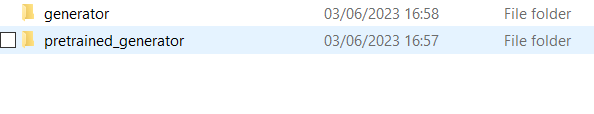

## PART 3_ TRY OUR MODEL

In [31]:
from tensorflow import distribute
from tensorflow.config import experimental_connect_to_cluster
from tensorflow.tpu.experimental import initialize_tpu_system
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.io.gfile import glob
from matplotlib.pyplot import subplots
import argparse
import sys
import os

In [34]:
# define the multi-gpu strategy
strategy = distribute.MirroredStrategy()

# set the train TFRecords, pretrained generator, and final
# generator model paths to be used for GPU training
tfrTestPath = GPU_DIV2K_TFR_TEST_PATH
pretrainedGenPath = r'C:\Users\Zeki\Desktop\kisisel calismalar\pyimageuni_notebooks\gans201\origin\srgan\outputs\models\pretrained_generator'
genPath = r'C:\Users\Zeki\Desktop\kisisel calismalar\pyimageuni_notebooks\gans201\origin\srgan\outputs\models\generator'

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [35]:
# get the dataset
print("[INFO] loading the test dataset...")
testTfr = glob(tfrTestPath + "/*.tfrec")
testDs = load_dataset(testTfr, INFER_BATCH_SIZE, train=False)

# get the first batch of testing images
(lrImage, hrImage) = next(iter(testDs))

# call the strategy scope context manager
with strategy.scope(): 
    # load the SRGAN trained models
    print("[INFO] loading the pre-trained and fully trained SRGAN model...")
    srganPreGen = load_model(pretrainedGenPath, compile=False)
    srganGen = load_model(genPath, compile=False)

    # predict using SRGAN
    print("[INFO] making predictions with pre-trained and fully trained SRGAN model...")
    srganPreGenPred = srganPreGen.predict(lrImage)
    srganGenPred = srganGen.predict(lrImage)

[INFO] loading the test dataset...
[INFO] loading the pre-trained and fully trained SRGAN model...


[INFO] making predictions with pre-trained and fully trained SRGAN model...


[INFO] plotting the SRGAN predictions...


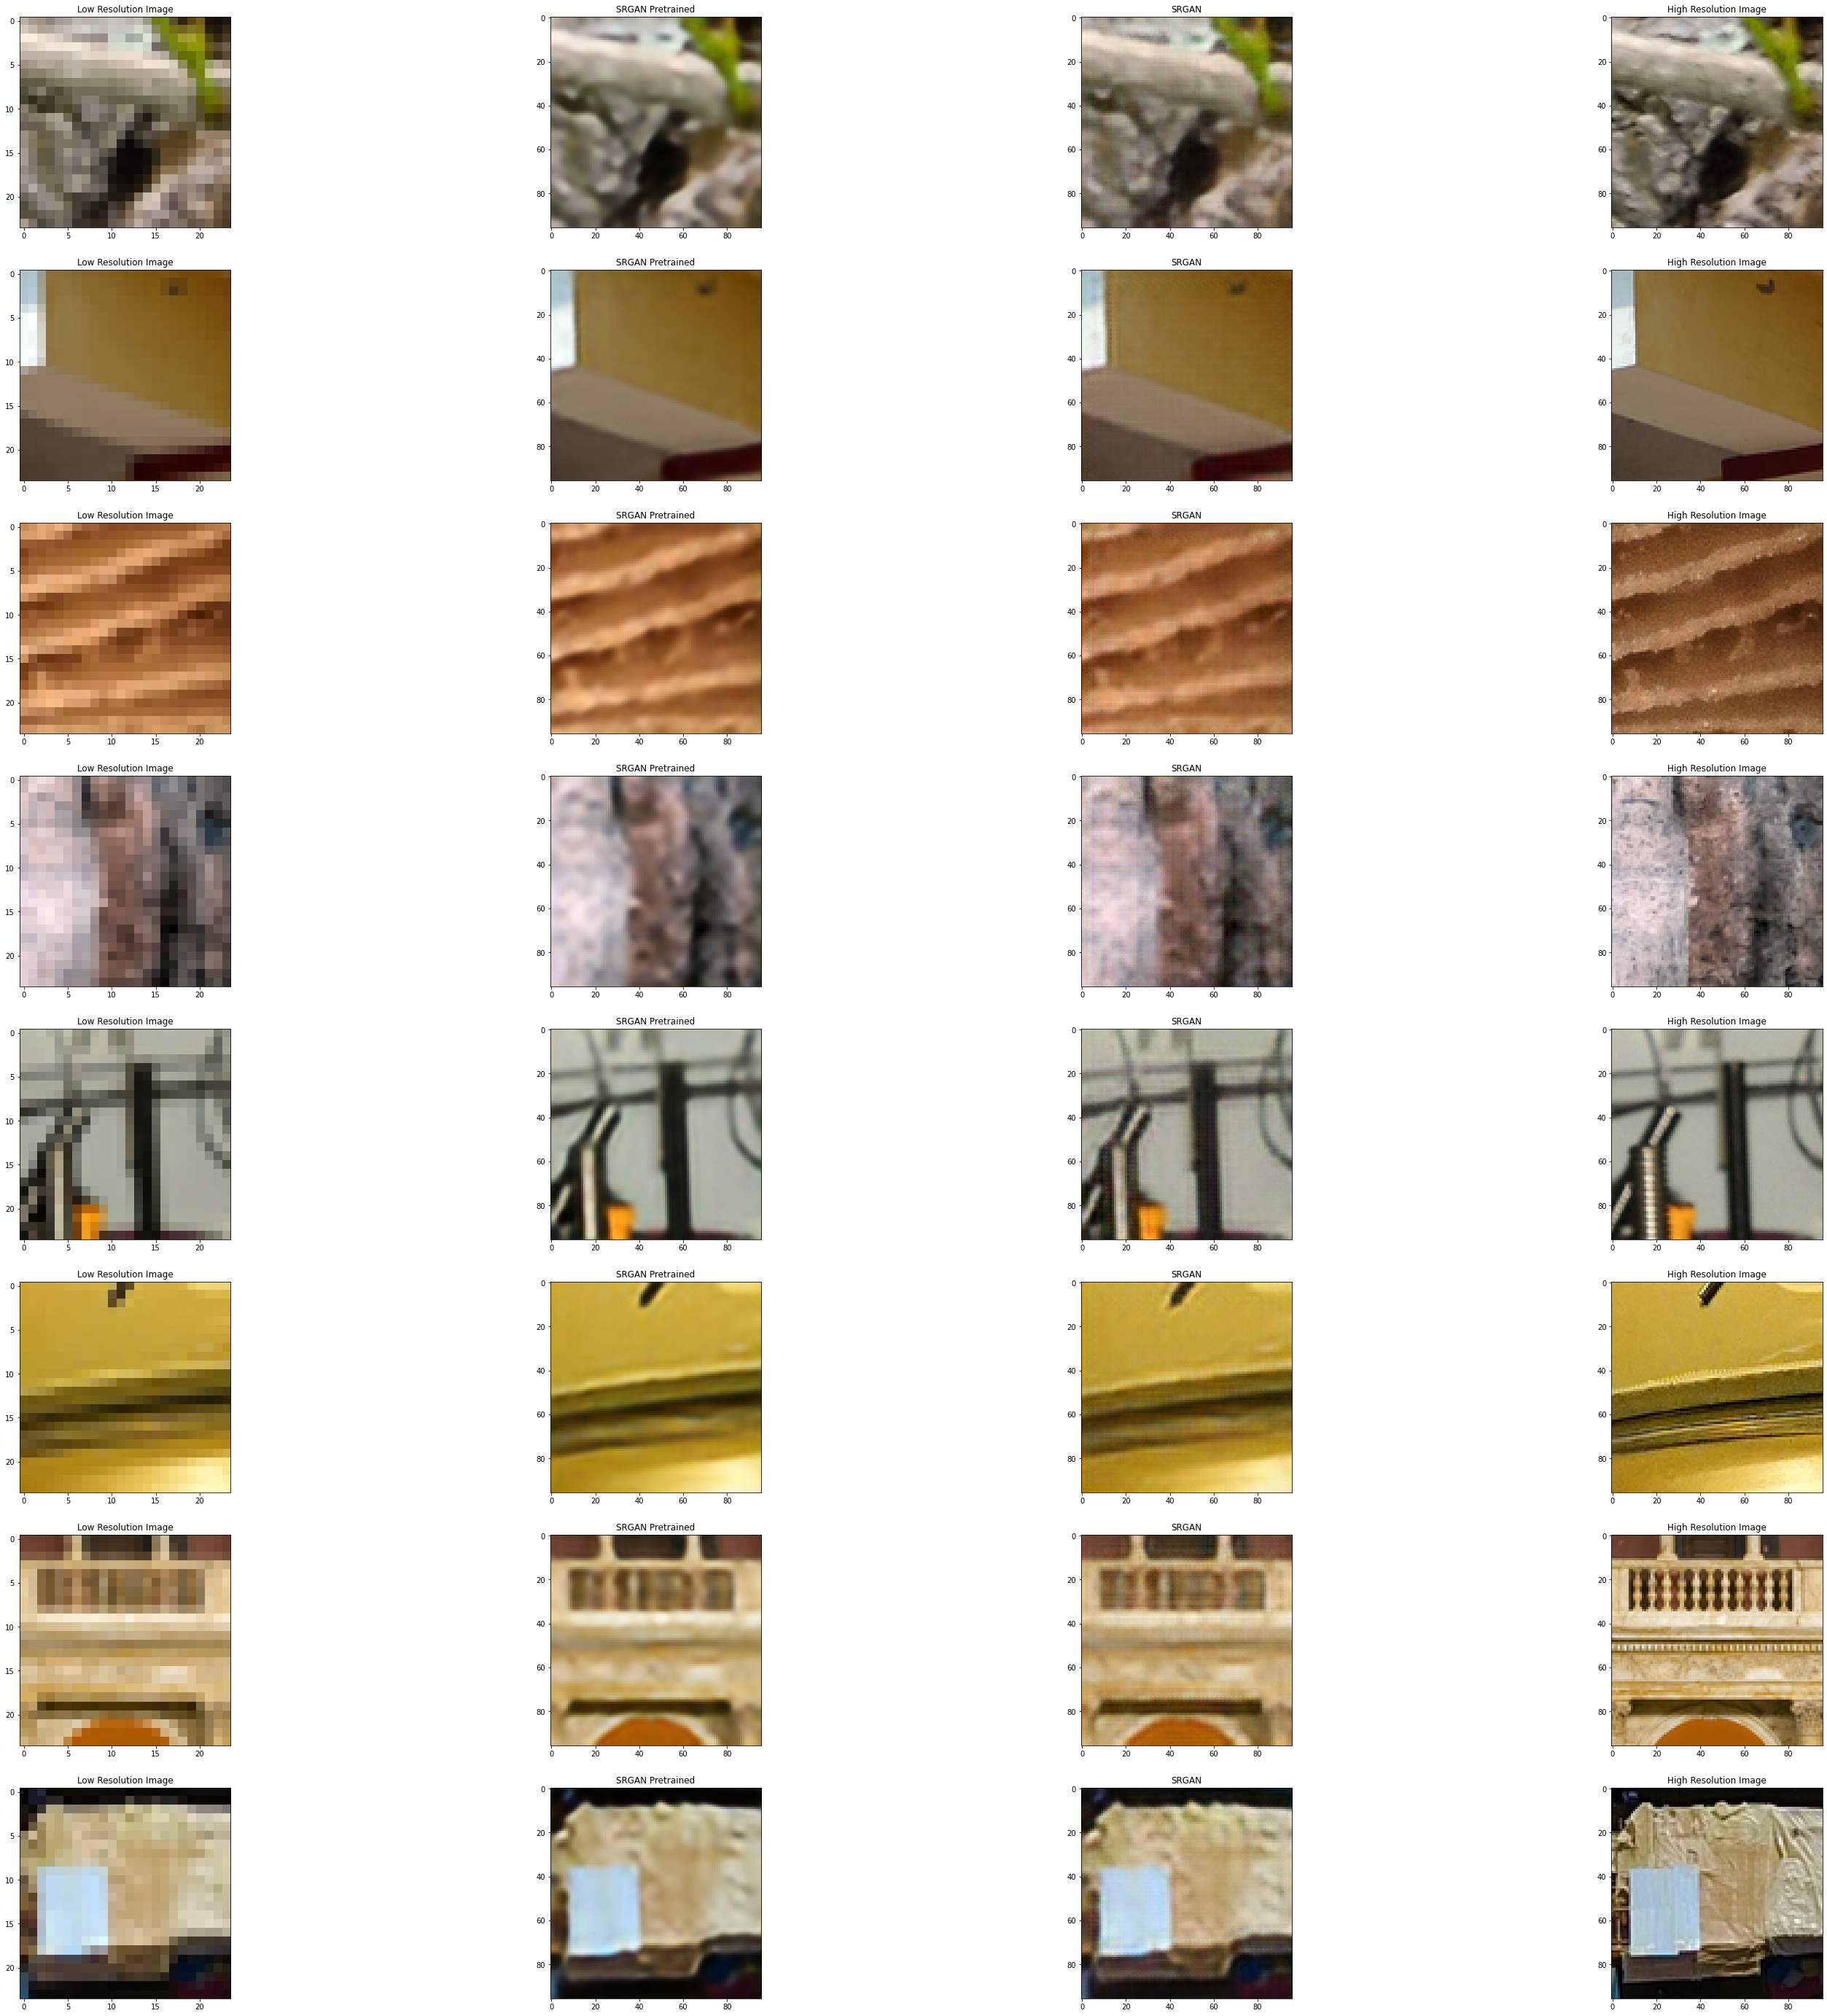

In [36]:
# plot the respective predictions
print("[INFO] plotting the SRGAN predictions...")
(fig, axes) = subplots(nrows=INFER_BATCH_SIZE, ncols=4,
    figsize=(50, 50))

# plot the predicted images from low res to high res
for (ax, lowRes, srPreIm, srGanIm, highRes) in zip(axes, lrImage,
        srganPreGenPred, srganGenPred, hrImage):
    # plot the low resolution image
    ax[0].imshow(array_to_img(lowRes))
    ax[0].set_title("Low Resolution Image")

    # plot the pretrained SRGAN image
    ax[1].imshow(array_to_img(srPreIm))
    ax[1].set_title("SRGAN Pretrained")

    # plot the SRGAN image
    ax[2].imshow(array_to_img(srGanIm))
    ax[2].set_title("SRGAN")

    # plot the high resolution image
    ax[3].imshow(array_to_img(highRes))
    ax[3].set_title("High Resolution Image")


In [37]:
# serialise the results to disk
print("[INFO] saving the SRGAN predictions to disk...")
fig.savefig('output_SRGAN.png')

[INFO] saving the SRGAN predictions to disk...


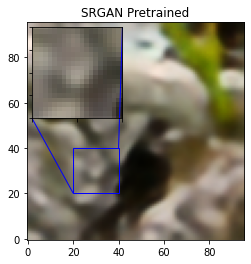

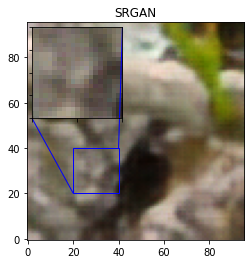

In [39]:
# plot the zoomed in images
zoom_into_images(srganPreGenPred[0], "SRGAN Pretrained")
zoom_into_images(srganGenPred[0], "SRGAN")

REFERENCES : 

Chakraborty, D. “Super-Resolution Generative Adversarial Networks (SRGAN),” PyImageSearch, P. Chugh, A. R. Gosthipaty, S. Huot, K. Kidriavsteva, R. Raha, and A. Thanki, eds., 2022, https://pyimg.co/lgnrx